# Stock Market Movement Prediction with LSTM Neural Networks
## CS 5824: Advanced Machine Learning
## Final Project
## Jostein Barry-Straume
## jostein@vt.edu

In [71]:
# Run the two commands below (in google Colab), installation steps to get .pdf of the notebook.
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

# Table of Contents
* [Team Members](#Team)
* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Related Work](#Related-Work)
* [Background](#Background)
* [Method](#Method)
* [Results and Evaluation](#Results)
* [Sources](#Sources)


# <a name="Team"></a>Team Members

* [Jostein Barry-Straume](https://github.com/josteinstraume)

# <a name="Abstract"></a>Abstract

> In this case study, the application of Long-Term Short-Term Neural Network towards various Financial Technical Indicators is presented.

# <a name="Introduction"></a>Introduction

# <a name="Related-Work"></a>Related Work

# <a name="Background"></a>Background

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

!pip install talos

import talos as ta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import random
import glob
import copy
from sklearn.preprocessing import MinMaxScaler
# Source:
# https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

random.seed(777)
np.random.seed(777)

%matplotlib inline

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Import test dataset
etfs = '/content/drive/My Drive/CS5824/data/final-project/ETFs/'
all_etfs = glob.glob(etfs + "/*.txt")
sample_etfs = all_etfs[:10]
#all_stocks = '/content/drive/My Drive/CS5824/data/final-project/ETFs/'

# Source:
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#df_etfs = pd.concat((pd.read_csv(f) for f in sample_etfs))
#df_stocks = pd.concat((pd.read_csv(f) for f in all_stocks))

'''
Iterate through each ETF, split the file path, and create
dataframe columns based on reformatted split filepath
'''
df_etfs = []
prefix = '/content/drive/My Drive/CS5824/data/final-project/ETFs/'
for etf in sample_etfs:
  df = pd.read_csv(etf)
  '''
  Get the name of the etf from the file path, split based on "." in file path
  and then remove everything in the string except for the etf name
  Source:
  https://stackoverflow.com/questions/16891340/remove-a-prefix-from-a-string
  '''
  df['Name'] = etf.split(sep='.')[0].replace(prefix, "", 1)
  df['Date'] = pd.to_datetime(df['Date'])
  df_etfs.append(df)

df_etfs = pd.concat(df_etfs)

In [4]:
'''
Check to see that data was imported properly
'''
df_etfs.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl


In [5]:
'''
Exploratory data analysis.
Visually inspect the given dataframe by plotting the
time series line plots for each stock, or ETF, in said
dataframe
'''
def make_plot(df):
  sns.set_theme(style="darkgrid")
  sns.lineplot(data=df,
               x=df['Date'],
               y=df['Close'],
               palette="tab10",
               linewidth=2.5,
               hue=df['Name']
               )
  plt.show()

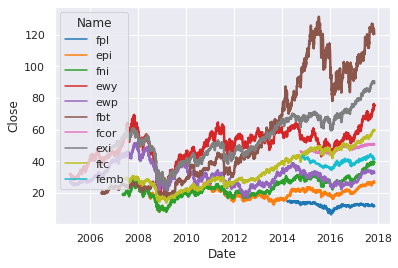

In [6]:
'''
Exploratory data analysis to check out
some of the ETFs in the imported dataset
'''
make_plot(df_etfs)

In [7]:
'''
Source:
https://www.kaggle.com/kratisaxena/lstm-gru-models-for-stock-movement-analysis

The purpose of this method is to calculate the Relative Strength Index
of a given array of values, and then to return those values respective
RSI values.
'''
def rsi(values):
  up = values[values>0].mean()
  down = -1*values[values<0].mean()
  return 100 * up / (up + down)

In [8]:
'''
# Source:
# https://github.com/borisbanushev/stockpredictionai

The purpose of this method is to calculate the various
Technical Indicators that will be used by the LSTM Neural Network as
learning component features.

New columns are created and added in the given dataframe, and the dataframe
is returned with the newly created and included technical indicators.

NOTE: data imputation is not performed at this step, and is done so in the
following code cell.
'''
def get_technical_indicators(dataset):
  # Create 7 and 21 days Moving Average
  dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
  dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

  # Create MACD
  dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
  dataset['12ema'] = dataset['Close'].ewm(span=26).mean()
  dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

  # Create Bollinger Bands
  dataset['20sd'] = dataset['Close'].rolling(20).std()
  dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
  dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

  # Create Exponential moving average
  dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

  # Create Momentum
  # Source: https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe
  dataset['momentum'] = (dataset['Close'] - dataset['Close'].shift(1))
  dataset['log_momentum'] = np.log(dataset['Close'] / dataset['Close'].shift(1))

  # Create 14 day RSI
  dataset['rsi_14d'] = dataset['momentum'].rolling(center=False, window=14).apply(rsi)

  return dataset

In [9]:
# Create a new dataset with the above technical indicators
df_ti = get_technical_indicators(df_etfs)

In [10]:
'''
Check that the technical indicators have been added to the dataframe.
'''
df_ti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl,NaN,NaN,14.729000,14.729000,0.0,NaN,NaN,NaN,14.729000,NaN,NaN,NaN
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl,NaN,NaN,14.729000,14.729000,0.0,NaN,NaN,NaN,14.729000,0.000,0.000000,NaN
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl,NaN,NaN,14.781816,14.781816,0.0,NaN,NaN,NaN,14.830769,0.147,0.009931,NaN
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl,NaN,NaN,14.767051,14.767051,0.0,NaN,NaN,NaN,14.762075,-0.147,-0.009931,NaN
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl,NaN,NaN,14.762401,14.762401,0.0,NaN,NaN,NaN,14.751983,0.018,0.001221,NaN


In [11]:
'''
Impute the dataframe's missing values with the median
values of each column.
'''
df_ti = df_ti.fillna(df_ti.median())

In [12]:
'''
Check that the missing values have been imputed.
'''
df_ti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.024,0.000713,49.724699
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.000,0.000000,49.724699
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl,32.818857,32.82819,14.781816,14.781816,0.0,0.67445,34.45069,31.105973,14.830769,0.147,0.009931,49.724699
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl,32.818857,32.82819,14.767051,14.767051,0.0,0.67445,34.45069,31.105973,14.762075,-0.147,-0.009931,49.724699
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl,32.818857,32.82819,14.762401,14.762401,0.0,0.67445,34.45069,31.105973,14.751983,0.018,0.001221,49.724699


In [13]:
'''
Source:
https://github.com/borisbanushev/stockpredictionai

The purpose of this method is to create a really great plot that shows
some of the technical indicators of a given stock or ETF.

The plot will illustrate the following technical indicators:
7 day moving average
21 day moving average
Upper and lower Bollinger Bands
Additionally, the adjusted closing price is also plotted for reference
'''
def plot_technical_indicators(dataset, last_days):
  plt.figure(figsize=(16, 10), dpi=100)
  shape_0 = dataset.shape[0]
  xmacd_ = shape_0-last_days

  dataset = dataset.iloc[-last_days:, :]
  x_ = range(3, dataset.shape[0])
  x_ =list(dataset.index)

  # Plot first subplot
  plt.subplot(2, 1, 1)
  plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
  plt.plot(dataset['Close'],label='Closing Price', color='b')
  plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
  plt.plot(dataset['upper_band'],label='Upper Band', color='c')
  plt.plot(dataset['lower_band'],label='Lower Band', color='c')
  plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
  plt.title('Technical indicators for {} - last {} days.'.format(dataset['Name'].values[0], last_days))
  plt.ylabel('USD')
  plt.legend()
  plt.show()

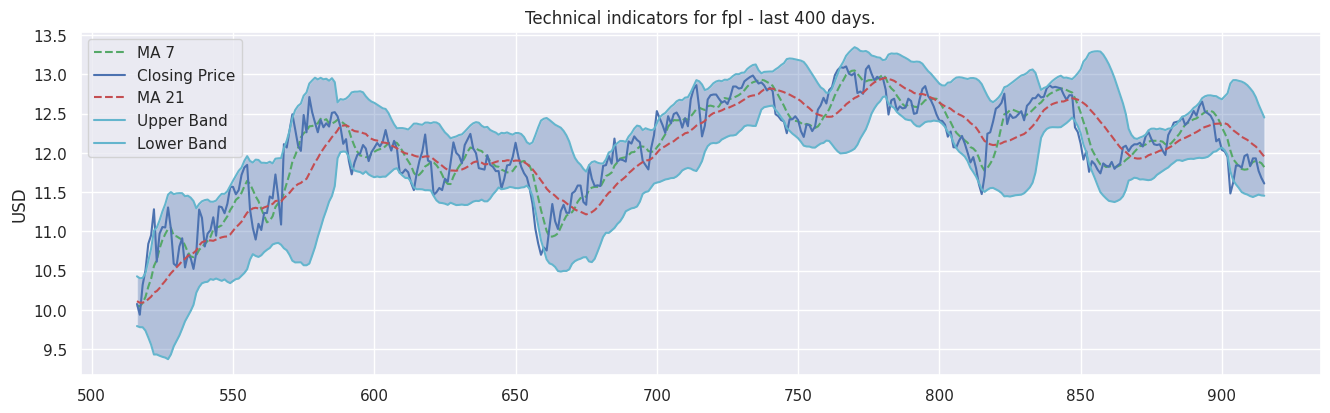

In [14]:
# Visually display the technical indicators
# for a given stock or ETF
plot_technical_indicators(df_ti[df_ti['Name'] == 'fpl'], 400)

# <a name="Method"></a>Method

In [15]:
'''
The purpose of this method is to normalize
the entire given dataframe to values from
zero to one based on the standard way of doing so:

Subtract the column's mean then divide by the standard deviation of the column
'''
def normalized_df(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [16]:
'''
Run analysis only on 1 ETF/stock for time purposes
'''
norm_df_ti = copy.deepcopy(df_ti[df_ti['Name'] == 'fpl'])

In [17]:
'''
Confirm that the deep copy function worked
'''
norm_df_ti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.024,0.000713,49.724699
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.000,0.000000,49.724699
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl,32.818857,32.82819,14.781816,14.781816,0.0,0.67445,34.45069,31.105973,14.830769,0.147,0.009931,49.724699
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl,32.818857,32.82819,14.767051,14.767051,0.0,0.67445,34.45069,31.105973,14.762075,-0.147,-0.009931,49.724699
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl,32.818857,32.82819,14.762401,14.762401,0.0,0.67445,34.45069,31.105973,14.751983,0.018,0.001221,49.724699


In [18]:
'''
Create an empty list to store the
names from the normalized technical
indicator dataframe.

Make the index of the dataframe the date column,
then subsequently drop the date column from the dataframe.
'''
ti_list = []

x = norm_df_ti['Name'][0]
ti_list.append(x)
norm_df_ti = norm_df_ti.drop('Name', 1)

norm_df_ti.index = norm_df_ti['Date']
norm_df_ti = norm_df_ti.drop('Date', 1)

In [19]:
'''
Confirm the name and date columns have been dropped,
as well as the date column being set
as the dataframe's index
'''
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
Date,,,,,,,,,,,,,,,,,,
2014-03-27,14.705,14.795,14.698,14.729,698621,0,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.024,0.000713,49.724699
2014-03-28,14.890,14.890,14.729,14.729,164979,0,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.000,0.000000,49.724699
2014-03-31,14.839,14.948,14.729,14.876,86108,0,32.818857,32.82819,14.781816,14.781816,0.0,0.67445,34.45069,31.105973,14.830769,0.147,0.009931,49.724699
2014-04-01,14.948,14.948,14.729,14.729,169637,0,32.818857,32.82819,14.767051,14.767051,0.0,0.67445,34.45069,31.105973,14.762075,-0.147,-0.009931,49.724699
2014-04-02,14.737,14.755,14.713,14.747,110332,0,32.818857,32.82819,14.762401,14.762401,0.0,0.67445,34.45069,31.105973,14.751983,0.018,0.001221,49.724699


In [20]:
'''
Regularize the dataframe
'''
mean = norm_df_ti.mean(axis = 0)
norm_df_ti -= mean
std = norm_df_ti.std(axis=0)
norm_df_ti /= std

In [21]:
'''
The purpose of this method is to
Add the label class based on whether
the stock/ETF goes up or down.

If the adjusted closing price of a
given day is equal to or greater than
that of the previous day's, then label
that observation with a 1. Otherwise,
label that observation with a 0.

Also additionally fill any NA values with 0.
'''
def add_label(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['Close'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label', value=new_col)
    df = df.fillna(0)

In [22]:
'''
Invoke the above function.
'''
add_label(norm_df_ti)

In [23]:
'''
Confirm that the label column
was created and added to the dataframe.
'''
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d,Label
Date,,,,,,,,,,,,,,,,,,,
2014-03-27,1.466345,1.482241,1.528187,1.504163,5.896101,NaN,8.848883,5.933812,1.512669,1.512669,NaN,2.048385,6.141559,5.64584,1.506837,0.133906,0.049320,-0.130599,0
2014-03-28,1.579972,1.541975,1.546829,1.504163,0.207128,NaN,8.848883,5.933812,1.512669,1.512669,NaN,2.048385,6.141559,5.64584,1.506837,0.016525,0.013137,-0.130599,1
2014-03-31,1.548648,1.578444,1.546829,1.594660,-0.633689,NaN,8.848883,5.933812,1.545881,1.545881,NaN,2.048385,6.141559,5.64584,1.569643,0.735483,0.516851,-0.130599,1
2014-04-01,1.615595,1.578444,1.546829,1.504163,0.256785,NaN,8.848883,5.933812,1.536596,1.536596,NaN,2.048385,6.141559,5.64584,1.527249,-0.702433,-0.490578,-0.130599,0
2014-04-02,1.486000,1.457090,1.537207,1.515244,-0.375445,NaN,8.848883,5.933812,1.533672,1.533672,NaN,2.048385,6.141559,5.64584,1.521021,0.104561,0.075086,-0.130599,1


In [24]:
'''
Fill any leftover NA values with zero
for data imputation purposes.
'''
norm_df_ti = norm_df_ti.fillna(0)

In [25]:
'''
Validate the data imputation was carried out.
'''
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d,Label
Date,,,,,,,,,,,,,,,,,,,
2014-03-27,1.466345,1.482241,1.528187,1.504163,5.896101,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.133906,0.049320,-0.130599,0
2014-03-28,1.579972,1.541975,1.546829,1.504163,0.207128,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.016525,0.013137,-0.130599,1
2014-03-31,1.548648,1.578444,1.546829,1.594660,-0.633689,0.0,8.848883,5.933812,1.545881,1.545881,0.0,2.048385,6.141559,5.64584,1.569643,0.735483,0.516851,-0.130599,1
2014-04-01,1.615595,1.578444,1.546829,1.504163,0.256785,0.0,8.848883,5.933812,1.536596,1.536596,0.0,2.048385,6.141559,5.64584,1.527249,-0.702433,-0.490578,-0.130599,0
2014-04-02,1.486000,1.457090,1.537207,1.515244,-0.375445,0.0,8.848883,5.933812,1.533672,1.533672,0.0,2.048385,6.141559,5.64584,1.521021,0.104561,0.075086,-0.130599,1


In [26]:
# Change dataframe into numpy array
#norm_df_ti = norm_df_ti.values

In [27]:
'''
Validate that the dataframe is still a Pandas dataframe.
'''
type(norm_df_ti)

pandas.core.frame.DataFrame

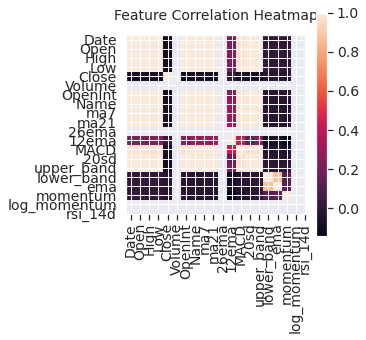

In [28]:
'''
The purpose of this method is to visualize
the correlation between features that
the LSTM neural network will learn on
'''
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df_ti)


# <a name="Results"></a>Results

In [29]:
'''
Gut check to see if the normalized dataframe
is still good to go for data ingestion.
'''
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d,Label
Date,,,,,,,,,,,,,,,,,,,
2014-03-27,1.466345,1.482241,1.528187,1.504163,5.896101,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.133906,0.049320,-0.130599,0
2014-03-28,1.579972,1.541975,1.546829,1.504163,0.207128,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.016525,0.013137,-0.130599,1
2014-03-31,1.548648,1.578444,1.546829,1.594660,-0.633689,0.0,8.848883,5.933812,1.545881,1.545881,0.0,2.048385,6.141559,5.64584,1.569643,0.735483,0.516851,-0.130599,1
2014-04-01,1.615595,1.578444,1.546829,1.504163,0.256785,0.0,8.848883,5.933812,1.536596,1.536596,0.0,2.048385,6.141559,5.64584,1.527249,-0.702433,-0.490578,-0.130599,0
2014-04-02,1.486000,1.457090,1.537207,1.515244,-0.375445,0.0,8.848883,5.933812,1.533672,1.533672,0.0,2.048385,6.141559,5.64584,1.521021,0.104561,0.075086,-0.130599,1


In [30]:
'''
Figure out the shape of the dataframe
'''
norm_df_ti.shape

(916, 19)

In [31]:
'''
Split the dataframe into a simply horizon dataframe
in which the first 800 days are used as training,
and the remaining days (116) are used for testing.
'''
X_train = norm_df_ti[norm_df_ti.columns[:-1]][:800]
X_test = norm_df_ti[norm_df_ti.columns[:-1]][800:]
y_train = norm_df_ti[norm_df_ti.columns[-1]][:800]
y_test = norm_df_ti[norm_df_ti.columns[-1]][800:]

'''
Keras uses numpy arrays, so get just the values
from the pandas dataframe, aka the underlying
numpy arrays to be used as train and test datasets.
'''
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

'''
Print out the shapes of train and test
for input and output
'''
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

'''
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
'''

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
y_train = y_train.reshape((y_train.shape[0], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 18)
(116, 18)
(800,)
(116,)
(800, 18)
(116, 18)
(800, 1)
(116, 1)


In [32]:
X_train.shape[0]

800

In [33]:
inputs = keras.layers.Input(shape=(X_train.shape[1], 1))
#inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model3 = keras.Model(inputs=inputs, outputs=outputs)

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test))
model3.evaluate(x=X_test, y=y_test)

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 3.8126 - accuracy: 0.5188 - val_loss: 1.2437 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.9940 - accuracy: 0.5238 - val_loss: 0.9542 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7512 - accuracy: 0.5362 - val_loss: 0.7928 - val_accuracy: 0.4655
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7134 - accuracy: 0.5875 - val_loss: 0.6671 - val_accuracy: 0.4741
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6801 - accuracy: 0.6975 - val_loss: 0.6348 - val_accuracy: 0.5690
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6474 - accuracy: 0.8050 - val_loss: 0.5983 - val_accuracy: 0.7931
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6135 - accuracy: 0.8087 - val_loss: 0.5772 - val_accuracy: 0.7759
Epoch 8/50
25/25 [=

[0.09460175782442093, 0.9741379022598267]

In [34]:
model3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [35]:
import talos as ta
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import binary_crossentropy

In [36]:
p = {'lr': (0.0001, 0.001, 0.005, 0.05, 0.01),
     'first_neuron': [8, 16, 32, 64],
     'epochs': [5, 10, 15, 20, 30, 40, 50],
     'optimizer': ['Adam', 'SGD', 'RMSprop'],
     'losses': ['binary_crossentropy']}

In [37]:
def build_lstm(X_train, y_train, X_test, y_test, params):
  inputs = keras.layers.Input(shape=(X_train.shape[1], 1))
  #inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
  lstm_out = keras.layers.LSTM(params['first_neuron'])(inputs)
  outputs = keras.layers.Dense(1)(lstm_out)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=params['optimizer'],
                loss=params['losses'],
                metrics=['accuracy'])
  history = model.fit(x=X_train, y=y_train, epochs=params['epochs'], validation_data=(X_test, y_test))
  return history, model

In [38]:
%time
scan_object = ta.Scan(x=X_train,
            y=y_train,
            model=build_lstm,
            params=p,
            seed=777,
            experiment_name='exp_run_1',
            x_val=X_test,
            y_val=y_test
           )

  0%|          | 0/84 [00:00<?, ?it/s]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 2.1297 - accuracy: 0.5350 - val_loss: 3.1523 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 1.3115 - accuracy: 0.5713 - val_loss: 1.6212 - val_accuracy: 0.4741
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.8045 - accuracy: 0.5925 - val_loss: 1.0082 - val_accuracy: 0.4741
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.6150 - val_loss: 0.8661 - val_accuracy: 0.4741
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6578 - accuracy: 0.6488 - val_loss: 0.8207 - val_accuracy: 0.4828


  1%|          | 1/84 [00:02<03:59,  2.88s/it]

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 0.6669 - accuracy: 0.6500 - val_loss: 0.6275 - val_accuracy: 0.5776
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5528 - accuracy: 0.7000 - val_loss: 0.6264 - val_accuracy: 0.5431
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5414 - accuracy: 0.7113 - val_loss: 0.5954 - val_accuracy: 0.6293
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5342 - accuracy: 0.7163 - val_loss: 0.5978 - val_accuracy: 0.6293
Epoch 5/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5417 - accuracy: 0.7100 - val_loss: 0.6138 - val_accuracy: 0.5690


  2%|▏         | 2/84 [00:05<03:56,  2.88s/it]

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 1.2630 - accuracy: 0.5188 - val_loss: 1.1487 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 0.7929 - accuracy: 0.5213 - val_loss: 0.8347 - val_accuracy: 0.4655
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6144 - accuracy: 0.6338 - val_loss: 0.6413 - val_accuracy: 0.5086
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5581 - accuracy: 0.6913 - val_loss: 0.5822 - val_accuracy: 0.7069
Epoch 5/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5347 - accuracy: 0.7138 - val_loss: 0.5845 - val_accuracy: 0.6810


  4%|▎         | 3/84 [00:08<03:56,  2.92s/it]

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 5.2919 - accuracy: 0.5138 - val_loss: 1.9261 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 1.9879 - accuracy: 0.5150 - val_loss: 0.9195 - val_accuracy: 0.4655
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.7788 - accuracy: 0.5050 - val_loss: 0.7532 - val_accuracy: 0.4655
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.7133 - accuracy: 0.5213 - val_loss: 0.7361 - val_accuracy: 0.4655
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5350 - val_loss: 0.7078 - val_accuracy: 0.4655


  5%|▍         | 4/84 [00:11<03:55,  2.94s/it]

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 1.0828 - accuracy: 0.5487 - val_loss: 0.6553 - val_accuracy: 0.6379
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6058 - accuracy: 0.6775 - val_loss: 0.6219 - val_accuracy: 0.6638
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5838 - accuracy: 0.6963 - val_loss: 0.6143 - val_accuracy: 0.6379
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5647 - accuracy: 0.7000 - val_loss: 0.5911 - val_accuracy: 0.6897
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5596 - accuracy: 0.7000 - val_loss: 0.6099 - val_accuracy: 0.6466


  6%|▌         | 5/84 [00:14<03:52,  2.94s/it]

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 0.9866 - accuracy: 0.5238 - val_loss: 1.0236 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6443 - accuracy: 0.5900 - val_loss: 0.6980 - val_accuracy: 0.4741
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5576 - accuracy: 0.7175 - val_loss: 0.5973 - val_accuracy: 0.5776
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5098 - accuracy: 0.8000 - val_loss: 0.5656 - val_accuracy: 0.6207
Epoch 5/5
25/25 [==============================] - 0s 5ms/step - loss: 0.4633 - accuracy: 0.7875 - val_loss: 0.5093 - val_accuracy: 0.7845


  7%|▋         | 6/84 [00:17<03:52,  2.99s/it]

Epoch 1/5
25/25 [==============================] - 1s 23ms/step - loss: 4.0203 - accuracy: 0.5175 - val_loss: 1.0199 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 0.8133 - accuracy: 0.5250 - val_loss: 0.7395 - val_accuracy: 0.4655
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 0.6649 - accuracy: 0.5750 - val_loss: 0.6785 - val_accuracy: 0.5345
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6358 - accuracy: 0.6612 - val_loss: 0.6661 - val_accuracy: 0.5345
Epoch 5/5
25/25 [==============================] - 0s 7ms/step - loss: 0.6111 - accuracy: 0.7625 - val_loss: 0.6469 - val_accuracy: 0.5862


  8%|▊         | 7/84 [00:20<03:55,  3.05s/it]

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 0.7873 - accuracy: 0.6075 - val_loss: 0.6321 - val_accuracy: 0.6810
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5739 - accuracy: 0.7050 - val_loss: 0.6199 - val_accuracy: 0.6379
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5482 - accuracy: 0.7125 - val_loss: 0.6008 - val_accuracy: 0.6638
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5482 - accuracy: 0.7125 - val_loss: 0.5795 - val_accuracy: 0.6983
Epoch 5/5
25/25 [==============================] - 0s 7ms/step - loss: 0.5394 - accuracy: 0.7175 - val_loss: 0.5957 - val_accuracy: 0.6466


 10%|▉         | 8/84 [00:24<03:52,  3.06s/it]

Epoch 1/5
25/25 [==============================] - 1s 23ms/step - loss: 1.3720 - accuracy: 0.5362 - val_loss: 0.8211 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 0.6651 - accuracy: 0.6775 - val_loss: 0.6146 - val_accuracy: 0.5690
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5593 - accuracy: 0.7688 - val_loss: 0.5324 - val_accuracy: 0.7328
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.4946 - accuracy: 0.8050 - val_loss: 0.4351 - val_accuracy: 0.8621
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.4544 - accuracy: 0.8213 - val_loss: 0.4229 - val_accuracy: 0.8190


 11%|█         | 9/84 [00:27<03:53,  3.11s/it]

Epoch 1/5
25/25 [==============================] - 1s 26ms/step - loss: 1.5290 - accuracy: 0.5288 - val_loss: 0.9096 - val_accuracy: 0.4741
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 0.6743 - accuracy: 0.6587 - val_loss: 0.6039 - val_accuracy: 0.5948
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 0.5980 - accuracy: 0.7475 - val_loss: 0.5896 - val_accuracy: 0.6034
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 0.5620 - accuracy: 0.7663 - val_loss: 0.5519 - val_accuracy: 0.6724
Epoch 5/5
25/25 [==============================] - 0s 9ms/step - loss: 0.5242 - accuracy: 0.7837 - val_loss: 0.5164 - val_accuracy: 0.7328


 12%|█▏        | 10/84 [00:30<03:59,  3.23s/it]

Epoch 1/5
25/25 [==============================] - 1s 26ms/step - loss: 1.7461 - accuracy: 0.6450 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/5
25/25 [==============================] - 0s 9ms/step - loss: 7.6101 - accuracy: 0.4900 - val_loss: 7.0003 - val_accuracy: 0.5345
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 7.5684 - accuracy: 0.4938 - val_loss: 6.8765 - val_accuracy: 0.5345
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 7.2590 - accuracy: 0.5050 - val_loss: 6.0128 - val_accuracy: 0.5603
Epoch 5/5
25/25 [==============================] - 0s 8ms/step - loss: 5.2470 - accuracy: 0.5675 - val_loss: 4.7147 - val_accuracy: 0.5000


 13%|█▎        | 11/84 [00:34<03:59,  3.28s/it]

Epoch 1/5
25/25 [==============================] - 1s 25ms/step - loss: 1.1774 - accuracy: 0.5738 - val_loss: 0.6674 - val_accuracy: 0.4914
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 0.5749 - accuracy: 0.7487 - val_loss: 0.5178 - val_accuracy: 0.7931
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 0.5133 - accuracy: 0.7725 - val_loss: 0.5493 - val_accuracy: 0.6207
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 0.4670 - accuracy: 0.8350 - val_loss: 0.3890 - val_accuracy: 0.8707
Epoch 5/5
25/25 [==============================] - 0s 10ms/step - loss: 0.4110 - accuracy: 0.8487 - val_loss: 0.3250 - val_accuracy: 0.9052


 14%|█▍        | 12/84 [00:37<04:02,  3.37s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 2.6074 - accuracy: 0.5188 - val_loss: 1.4444 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.1507 - accuracy: 0.5188 - val_loss: 1.1069 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8814 - accuracy: 0.5188 - val_loss: 0.9605 - val_accuracy: 0.4655
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7767 - accuracy: 0.5188 - val_loss: 0.8507 - val_accuracy: 0.4655
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.5288 - val_loss: 0.7634 - val_accuracy: 0.4655
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.5825 - val_loss: 0.6946 - val_accuracy: 0.4741
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6116 - accuracy: 0.6375 - val_loss: 0.6571 - val_accuracy: 0.5000
Epoch 8/10
25/25 [=

 15%|█▌        | 13/84 [00:41<04:07,  3.49s/it]

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 1.0133 - accuracy: 0.5487 - val_loss: 0.6581 - val_accuracy: 0.6983
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6812 - val_loss: 0.6407 - val_accuracy: 0.5431
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5828 - accuracy: 0.7125 - val_loss: 0.6359 - val_accuracy: 0.5345
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5570 - accuracy: 0.7075 - val_loss: 0.6192 - val_accuracy: 0.5603
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5388 - accuracy: 0.7088 - val_loss: 0.6234 - val_accuracy: 0.5517
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5270 - accuracy: 0.7125 - val_loss: 0.6270 - val_accuracy: 0.5431
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5191 - accuracy: 0.7150 - val_loss: 0.6078 - val_accuracy: 0.5603
Epoch 8/10
25/25 [=

 17%|█▋        | 14/84 [00:45<04:09,  3.56s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 2.0920 - accuracy: 0.5188 - val_loss: 2.4569 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.5765 - accuracy: 0.5188 - val_loss: 1.4016 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9361 - accuracy: 0.5250 - val_loss: 0.9474 - val_accuracy: 0.4655
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.7276 - accuracy: 0.5575 - val_loss: 0.7529 - val_accuracy: 0.4741
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5794 - accuracy: 0.6787 - val_loss: 0.6039 - val_accuracy: 0.5690
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5296 - accuracy: 0.7350 - val_loss: 0.5757 - val_accuracy: 0.6379
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5041 - accuracy: 0.7575 - val_loss: 0.5459 - val_accuracy: 0.7500
Epoch 8/10
25/25 [=

 18%|█▊        | 15/84 [00:49<04:12,  3.66s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 1.6889 - accuracy: 0.5188 - val_loss: 1.2544 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9257 - accuracy: 0.5175 - val_loss: 1.0534 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7920 - accuracy: 0.5312 - val_loss: 0.9376 - val_accuracy: 0.4655
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7035 - accuracy: 0.5487 - val_loss: 0.8425 - val_accuracy: 0.4655
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6425 - accuracy: 0.5950 - val_loss: 0.7617 - val_accuracy: 0.4741
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6056 - accuracy: 0.6363 - val_loss: 0.7046 - val_accuracy: 0.4741
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5777 - accuracy: 0.6737 - val_loss: 0.6680 - val_accuracy: 0.4828
Epoch 8/10
25/25 [=

 19%|█▉        | 16/84 [00:53<04:14,  3.75s/it]

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 1.3675 - accuracy: 0.4588 - val_loss: 0.6711 - val_accuracy: 0.5862
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6468 - accuracy: 0.6587 - val_loss: 0.6273 - val_accuracy: 0.7500
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5896 - accuracy: 0.7200 - val_loss: 0.6035 - val_accuracy: 0.7069
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5553 - accuracy: 0.7300 - val_loss: 0.5821 - val_accuracy: 0.7155
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5350 - accuracy: 0.7237 - val_loss: 0.5768 - val_accuracy: 0.6810
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5215 - accuracy: 0.7275 - val_loss: 0.5686 - val_accuracy: 0.6810
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5134 - accuracy: 0.7200 - val_loss: 0.5587 - val_accuracy: 0.6810
Epoch 8/10
25/25 [=

 20%|██        | 17/84 [00:56<04:11,  3.75s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 1.3394 - accuracy: 0.5213 - val_loss: 1.1507 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7547 - accuracy: 0.5412 - val_loss: 0.7884 - val_accuracy: 0.4741
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6662 - val_loss: 0.6169 - val_accuracy: 0.5517
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5850 - accuracy: 0.7538 - val_loss: 0.5332 - val_accuracy: 0.7586
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5429 - accuracy: 0.7713 - val_loss: 0.5330 - val_accuracy: 0.7241
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5203 - accuracy: 0.7900 - val_loss: 0.4784 - val_accuracy: 0.7931
Epoch 7/10
25/25 [==============================] - 0s 8ms/step - loss: 0.4939 - accuracy: 0.7962 - val_loss: 0.4622 - val_accuracy: 0.8103
Epoch 8/10
25/25 [=

 21%|██▏       | 18/84 [01:00<04:13,  3.85s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 2.7350 - accuracy: 0.5375 - val_loss: 1.0280 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.9045 - accuracy: 0.5700 - val_loss: 0.8090 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6554 - accuracy: 0.5975 - val_loss: 0.7211 - val_accuracy: 0.4741
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5923 - accuracy: 0.6488 - val_loss: 0.6617 - val_accuracy: 0.4828
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5444 - accuracy: 0.7500 - val_loss: 0.6002 - val_accuracy: 0.5776
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5145 - accuracy: 0.8100 - val_loss: 0.5726 - val_accuracy: 0.7069
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4771 - accuracy: 0.8263 - val_loss: 0.5232 - val_accuracy: 0.8103
Epoch 8/10
25/25 [=

 23%|██▎       | 19/84 [01:05<04:14,  3.92s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 7.8798 - accuracy: 0.4762 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/10
25/25 [=

 24%|██▍       | 20/84 [01:09<04:12,  3.95s/it]

Epoch 1/10
25/25 [==============================] - 1s 24ms/step - loss: 1.0606 - accuracy: 0.5362 - val_loss: 0.8654 - val_accuracy: 0.4741
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6451 - accuracy: 0.6950 - val_loss: 0.6191 - val_accuracy: 0.5690
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5651 - accuracy: 0.7625 - val_loss: 0.5331 - val_accuracy: 0.7069
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5100 - accuracy: 0.7750 - val_loss: 0.4839 - val_accuracy: 0.7759
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4864 - accuracy: 0.8037 - val_loss: 0.4270 - val_accuracy: 0.8276
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4481 - accuracy: 0.8375 - val_loss: 0.3677 - val_accuracy: 0.8707
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4039 - accuracy: 0.8637 - val_loss: 0.3190 - val_accuracy: 0.9138
Epoch 8/10
25/25 [=

 25%|██▌       | 21/84 [01:13<04:14,  4.04s/it]

Epoch 1/10
25/25 [==============================] - 1s 26ms/step - loss: 1.2446 - accuracy: 0.5238 - val_loss: 1.0871 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.7437 - accuracy: 0.5487 - val_loss: 0.7952 - val_accuracy: 0.4741
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.6398 - accuracy: 0.6837 - val_loss: 0.6068 - val_accuracy: 0.5948
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.6033 - accuracy: 0.7812 - val_loss: 0.5872 - val_accuracy: 0.5948
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5620 - accuracy: 0.7850 - val_loss: 0.5525 - val_accuracy: 0.6897
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5270 - accuracy: 0.7925 - val_loss: 0.5172 - val_accuracy: 0.7759
Epoch 7/10
25/25 [==============================] - 0s 10ms/step - loss: 0.5024 - accuracy: 0.7937 - val_loss: 0.5122 - val_accuracy: 0.6983
Epoch 8/10
25/25 [

 26%|██▌       | 22/84 [01:18<04:22,  4.24s/it]

Epoch 1/10
25/25 [==============================] - 1s 26ms/step - loss: 0.9170 - accuracy: 0.6100 - val_loss: 0.6446 - val_accuracy: 0.5690
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5783 - accuracy: 0.7025 - val_loss: 0.6065 - val_accuracy: 0.6810
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5669 - accuracy: 0.7125 - val_loss: 0.6168 - val_accuracy: 0.6121
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5541 - accuracy: 0.7088 - val_loss: 0.5913 - val_accuracy: 0.6810
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5588 - accuracy: 0.7125 - val_loss: 0.6097 - val_accuracy: 0.6379
Epoch 6/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5516 - accuracy: 0.7050 - val_loss: 0.5874 - val_accuracy: 0.6810
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5464 - accuracy: 0.7188 - val_loss: 0.6130 - val_accuracy: 0.6466
Epoch 8/10
25/25 [=

 27%|██▋       | 23/84 [01:22<04:25,  4.36s/it]

Epoch 1/10
25/25 [==============================] - 1s 25ms/step - loss: 1.0968 - accuracy: 0.5788 - val_loss: 0.6845 - val_accuracy: 0.4914
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5908 - accuracy: 0.7425 - val_loss: 0.5852 - val_accuracy: 0.5948
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5265 - accuracy: 0.7925 - val_loss: 0.4763 - val_accuracy: 0.7931
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 0.4681 - accuracy: 0.8238 - val_loss: 0.4713 - val_accuracy: 0.7241
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.4073 - accuracy: 0.8562 - val_loss: 0.3336 - val_accuracy: 0.9224
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.3606 - accuracy: 0.8888 - val_loss: 0.2686 - val_accuracy: 0.9310
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.3104 - accuracy: 0.9025 - val_loss: 0.2682 - val_accuracy: 0.8793
Epoch 8/10
25/25 [=

 29%|██▊       | 24/84 [01:27<04:28,  4.47s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 2.4366 - accuracy: 0.5412 - val_loss: 3.6106 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 1.9208 - accuracy: 0.5512 - val_loss: 3.0607 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 5ms/step - loss: 1.8186 - accuracy: 0.5600 - val_loss: 2.7805 - val_accuracy: 0.4655
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 1.7581 - accuracy: 0.5638 - val_loss: 2.6638 - val_accuracy: 0.4655
Epoch 5/15
25/25 [==============================] - 0s 7ms/step - loss: 1.7193 - accuracy: 0.5750 - val_loss: 2.6303 - val_accuracy: 0.4655
Epoch 6/15
25/25 [==============================] - 0s 5ms/step - loss: 1.6679 - accuracy: 0.5838 - val_loss: 2.5775 - val_accuracy: 0.4655
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 1.5302 - accuracy: 0.5888 - val_loss: 2.2906 - val_accuracy: 0.4655
Epoch 8/15
25/25 [=

 30%|██▉       | 25/84 [01:31<04:25,  4.49s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 0.9781 - accuracy: 0.6550 - val_loss: 0.6103 - val_accuracy: 0.6810
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5633 - accuracy: 0.7312 - val_loss: 0.5976 - val_accuracy: 0.6638
Epoch 3/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5422 - accuracy: 0.7375 - val_loss: 0.5901 - val_accuracy: 0.6552
Epoch 4/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5281 - accuracy: 0.7337 - val_loss: 0.5739 - val_accuracy: 0.6810
Epoch 5/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5184 - accuracy: 0.7275 - val_loss: 0.5733 - val_accuracy: 0.6724
Epoch 6/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5114 - accuracy: 0.7400 - val_loss: 0.5546 - val_accuracy: 0.7155
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5066 - accuracy: 0.7337 - val_loss: 0.5500 - val_accuracy: 0.7155
Epoch 8/15
25/25 [=

 31%|███       | 26/84 [01:36<04:19,  4.47s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 2.0567 - accuracy: 0.6650 - val_loss: 3.3629 - val_accuracy: 0.4914
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 1.6166 - accuracy: 0.6812 - val_loss: 2.7324 - val_accuracy: 0.5086
Epoch 3/15
25/25 [==============================] - 0s 7ms/step - loss: 1.3686 - accuracy: 0.6913 - val_loss: 2.5222 - val_accuracy: 0.5172
Epoch 4/15
25/25 [==============================] - 0s 5ms/step - loss: 1.3189 - accuracy: 0.6875 - val_loss: 2.3614 - val_accuracy: 0.5172
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 1.1997 - accuracy: 0.7000 - val_loss: 1.8279 - val_accuracy: 0.5431
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.9331 - accuracy: 0.7050 - val_loss: 1.2057 - val_accuracy: 0.5690
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.7968 - accuracy: 0.7237 - val_loss: 0.8472 - val_accuracy: 0.6379
Epoch 8/15
25/25 [=

 32%|███▏      | 27/84 [01:40<04:17,  4.52s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 4.1755 - accuracy: 0.5188 - val_loss: 1.3770 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 1.5771 - accuracy: 0.5238 - val_loss: 0.9685 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.8363 - accuracy: 0.5325 - val_loss: 0.8660 - val_accuracy: 0.4655
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.7670 - accuracy: 0.5312 - val_loss: 0.8111 - val_accuracy: 0.4655
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.7257 - accuracy: 0.5312 - val_loss: 0.7663 - val_accuracy: 0.4655
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5362 - val_loss: 0.7297 - val_accuracy: 0.4655
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6694 - accuracy: 0.5650 - val_loss: 0.7012 - val_accuracy: 0.4655
Epoch 8/15
25/25 [=

 33%|███▎      | 28/84 [01:45<04:16,  4.58s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 1.0644 - accuracy: 0.4775 - val_loss: 0.6755 - val_accuracy: 0.5345
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.6525 - val_loss: 0.6501 - val_accuracy: 0.5000
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5859 - accuracy: 0.6837 - val_loss: 0.6342 - val_accuracy: 0.5431
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5656 - accuracy: 0.6888 - val_loss: 0.6267 - val_accuracy: 0.5603
Epoch 5/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5502 - accuracy: 0.7013 - val_loss: 0.5980 - val_accuracy: 0.6293
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5527 - accuracy: 0.7063 - val_loss: 0.6163 - val_accuracy: 0.5690
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5453 - accuracy: 0.7113 - val_loss: 0.5973 - val_accuracy: 0.6293
Epoch 8/15
25/25 [=

 35%|███▍      | 29/84 [01:50<04:11,  4.57s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 1.4125 - accuracy: 0.5188 - val_loss: 1.1104 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.7826 - accuracy: 0.5275 - val_loss: 0.8393 - val_accuracy: 0.4741
Epoch 3/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5905 - accuracy: 0.6500 - val_loss: 0.6004 - val_accuracy: 0.6552
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5844 - accuracy: 0.7250 - val_loss: 0.5892 - val_accuracy: 0.6379
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5528 - accuracy: 0.7437 - val_loss: 0.5984 - val_accuracy: 0.6207
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.4872 - accuracy: 0.7450 - val_loss: 0.5555 - val_accuracy: 0.6810
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.4848 - accuracy: 0.7475 - val_loss: 0.5394 - val_accuracy: 0.7155
Epoch 8/15
25/25 [=

 36%|███▌      | 30/84 [01:55<04:10,  4.64s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 4.4020 - accuracy: 0.5100 - val_loss: 1.2493 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 7ms/step - loss: 1.1710 - accuracy: 0.5113 - val_loss: 0.8305 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 7ms/step - loss: 0.7146 - accuracy: 0.5375 - val_loss: 0.7152 - val_accuracy: 0.4655
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6683 - accuracy: 0.5512 - val_loss: 0.7041 - val_accuracy: 0.4655
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6437 - accuracy: 0.5950 - val_loss: 0.6738 - val_accuracy: 0.4741
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6128 - accuracy: 0.6925 - val_loss: 0.6465 - val_accuracy: 0.5517
Epoch 7/15
25/25 [==============================] - 0s 7ms/step - loss: 0.5855 - accuracy: 0.7325 - val_loss: 0.6320 - val_accuracy: 0.5431
Epoch 8/15
25/25 [=

 37%|███▋      | 31/84 [02:00<04:11,  4.75s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 1.1753 - accuracy: 0.5013 - val_loss: 0.6576 - val_accuracy: 0.7931
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6135 - accuracy: 0.6900 - val_loss: 0.6197 - val_accuracy: 0.6207
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5643 - accuracy: 0.7013 - val_loss: 0.5898 - val_accuracy: 0.6983
Epoch 4/15
25/25 [==============================] - 0s 7ms/step - loss: 0.5404 - accuracy: 0.7175 - val_loss: 0.5892 - val_accuracy: 0.6379
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5418 - accuracy: 0.7237 - val_loss: 0.5807 - val_accuracy: 0.6552
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5285 - accuracy: 0.7212 - val_loss: 0.5803 - val_accuracy: 0.6466
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5195 - accuracy: 0.7312 - val_loss: 0.5672 - val_accuracy: 0.6810
Epoch 8/15
25/25 [=

 38%|███▊      | 32/84 [02:04<04:07,  4.77s/it]

Epoch 1/15
25/25 [==============================] - 1s 24ms/step - loss: 1.2343 - accuracy: 0.5362 - val_loss: 0.7141 - val_accuracy: 0.4741
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6151 - accuracy: 0.7350 - val_loss: 0.5912 - val_accuracy: 0.6034
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5452 - accuracy: 0.8225 - val_loss: 0.4963 - val_accuracy: 0.8276
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.4798 - accuracy: 0.8125 - val_loss: 0.4140 - val_accuracy: 0.8276
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.4437 - accuracy: 0.8487 - val_loss: 0.4270 - val_accuracy: 0.8017
Epoch 6/15
25/25 [==============================] - 0s 7ms/step - loss: 0.4029 - accuracy: 0.8650 - val_loss: 0.3307 - val_accuracy: 0.9224
Epoch 7/15
25/25 [==============================] - 0s 7ms/step - loss: 0.3762 - accuracy: 0.8938 - val_loss: 0.2799 - val_accuracy: 0.9224
Epoch 8/15
25/25 [=

 39%|███▉      | 33/84 [02:09<04:07,  4.85s/it]

Epoch 1/15
25/25 [==============================] - 1s 26ms/step - loss: 2.3714 - accuracy: 0.5188 - val_loss: 0.9710 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 8ms/step - loss: 0.7496 - accuracy: 0.5350 - val_loss: 0.7844 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6651 - accuracy: 0.5900 - val_loss: 0.6720 - val_accuracy: 0.4741
Epoch 4/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6642 - accuracy: 0.7450 - val_loss: 0.6229 - val_accuracy: 0.5776
Epoch 5/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6322 - accuracy: 0.7937 - val_loss: 0.6075 - val_accuracy: 0.5862
Epoch 6/15
25/25 [==============================] - 0s 8ms/step - loss: 0.5983 - accuracy: 0.8125 - val_loss: 0.5781 - val_accuracy: 0.6724
Epoch 7/15
25/25 [==============================] - 0s 8ms/step - loss: 0.5636 - accuracy: 0.8012 - val_loss: 0.5688 - val_accuracy: 0.6207
Epoch 8/15
25/25 [=

 40%|████      | 34/84 [02:15<04:17,  5.14s/it]

Epoch 1/15
25/25 [==============================] - 1s 25ms/step - loss: 0.7397 - accuracy: 0.6862 - val_loss: 0.6173 - val_accuracy: 0.6293
Epoch 2/15
25/25 [==============================] - 0s 9ms/step - loss: 0.5565 - accuracy: 0.7025 - val_loss: 0.6073 - val_accuracy: 0.6293
Epoch 3/15
25/25 [==============================] - 0s 9ms/step - loss: 0.5522 - accuracy: 0.7088 - val_loss: 0.5850 - val_accuracy: 0.7069
Epoch 4/15
25/25 [==============================] - 0s 8ms/step - loss: 2.3226 - accuracy: 0.6100 - val_loss: 2.9513 - val_accuracy: 0.4828
Epoch 5/15
25/25 [==============================] - 0s 8ms/step - loss: 2.1205 - accuracy: 0.5138 - val_loss: 0.6626 - val_accuracy: 0.6034
Epoch 6/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6169 - accuracy: 0.6888 - val_loss: 0.6346 - val_accuracy: 0.6466
Epoch 7/15
25/25 [==============================] - 0s 9ms/step - loss: 0.5785 - accuracy: 0.6925 - val_loss: 0.6146 - val_accuracy: 0.6724
Epoch 8/15
25/25 [=

 42%|████▏     | 35/84 [02:21<04:21,  5.34s/it]

Epoch 1/15
25/25 [==============================] - 1s 25ms/step - loss: 1.9167 - accuracy: 0.5250 - val_loss: 0.9765 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 10ms/step - loss: 0.7413 - accuracy: 0.6062 - val_loss: 0.6589 - val_accuracy: 0.5086
Epoch 3/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6002 - accuracy: 0.7550 - val_loss: 0.5270 - val_accuracy: 0.7759
Epoch 4/15
25/25 [==============================] - 0s 8ms/step - loss: 0.4824 - accuracy: 0.8300 - val_loss: 0.4670 - val_accuracy: 0.6983
Epoch 5/15
25/25 [==============================] - 0s 8ms/step - loss: 0.3833 - accuracy: 0.8875 - val_loss: 0.2772 - val_accuracy: 0.9397
Epoch 6/15
25/25 [==============================] - 0s 9ms/step - loss: 0.3921 - accuracy: 0.9050 - val_loss: 0.2485 - val_accuracy: 0.9310
Epoch 7/15
25/25 [==============================] - 0s 9ms/step - loss: 0.2736 - accuracy: 0.9312 - val_loss: 0.2038 - val_accuracy: 0.9310
Epoch 8/15
25/25 [

 43%|████▎     | 36/84 [02:27<04:25,  5.54s/it]

Epoch 1/20
25/25 [==============================] - 1s 22ms/step - loss: 1.7640 - accuracy: 0.5188 - val_loss: 1.3833 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.9468 - accuracy: 0.5188 - val_loss: 1.0817 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.7820 - accuracy: 0.5312 - val_loss: 0.9276 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6769 - accuracy: 0.5700 - val_loss: 0.7974 - val_accuracy: 0.4741
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6068 - accuracy: 0.6388 - val_loss: 0.6959 - val_accuracy: 0.4828
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5897 - accuracy: 0.6687 - val_loss: 0.6565 - val_accuracy: 0.5000
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5724 - accuracy: 0.6913 - val_loss: 0.6362 - val_accuracy: 0.5172
Epoch 8/20
25/25 [=

 44%|████▍     | 37/84 [02:32<04:16,  5.45s/it]

Epoch 1/20
25/25 [==============================] - 1s 21ms/step - loss: 1.7793 - accuracy: 0.4013 - val_loss: 0.7108 - val_accuracy: 0.3276
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.5625 - val_loss: 0.6628 - val_accuracy: 0.4741
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6033 - accuracy: 0.6775 - val_loss: 0.6246 - val_accuracy: 0.5259
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5673 - accuracy: 0.7013 - val_loss: 0.6125 - val_accuracy: 0.5259
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5472 - accuracy: 0.7000 - val_loss: 0.5851 - val_accuracy: 0.5948
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5379 - accuracy: 0.6938 - val_loss: 0.5880 - val_accuracy: 0.5862
Epoch 7/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5446 - accuracy: 0.7025 - val_loss: 0.5802 - val_accuracy: 0.5948
Epoch 8/20
25/25 [=

 45%|████▌     | 38/84 [02:37<04:07,  5.37s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 4.7522 - accuracy: 0.5188 - val_loss: 1.9688 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 2.3460 - accuracy: 0.5188 - val_loss: 1.3124 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 1.5891 - accuracy: 0.5188 - val_loss: 0.9940 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 0.9777 - accuracy: 0.5188 - val_loss: 0.7836 - val_accuracy: 0.4655
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6672 - accuracy: 0.5587 - val_loss: 0.6614 - val_accuracy: 0.5000
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5746 - accuracy: 0.7113 - val_loss: 0.6049 - val_accuracy: 0.6724
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.7262 - val_loss: 0.5711 - val_accuracy: 0.7414
Epoch 8/20
25/25 [=

 46%|████▋     | 39/84 [02:43<04:01,  5.36s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 2.2160 - accuracy: 0.5188 - val_loss: 2.0342 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 1.1725 - accuracy: 0.5188 - val_loss: 1.2836 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.9336 - accuracy: 0.5188 - val_loss: 1.1261 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.8363 - accuracy: 0.5200 - val_loss: 1.0145 - val_accuracy: 0.4655
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7516 - accuracy: 0.5337 - val_loss: 0.9013 - val_accuracy: 0.4655
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6580 - accuracy: 0.5713 - val_loss: 0.7904 - val_accuracy: 0.4741
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6240 - accuracy: 0.6413 - val_loss: 0.6959 - val_accuracy: 0.4828
Epoch 8/20
25/25 [=

 48%|████▊     | 40/84 [02:48<03:57,  5.39s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 0.8363 - accuracy: 0.6050 - val_loss: 0.6252 - val_accuracy: 0.7155
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5828 - accuracy: 0.7188 - val_loss: 0.6210 - val_accuracy: 0.5776
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.6950 - val_loss: 0.6082 - val_accuracy: 0.5948
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5479 - accuracy: 0.6988 - val_loss: 0.5943 - val_accuracy: 0.6293
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5379 - accuracy: 0.7038 - val_loss: 0.5840 - val_accuracy: 0.6552
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5325 - accuracy: 0.7100 - val_loss: 0.5830 - val_accuracy: 0.6466
Epoch 7/20
25/25 [==============================] - 0s 5ms/step - loss: 0.9765 - accuracy: 0.6488 - val_loss: 0.7910 - val_accuracy: 0.4655
Epoch 8/20
25/25 [=

 49%|████▉     | 41/84 [02:54<03:50,  5.36s/it]

Epoch 1/20
25/25 [==============================] - 1s 22ms/step - loss: 2.2406 - accuracy: 0.5200 - val_loss: 0.9247 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.7315 - accuracy: 0.5400 - val_loss: 0.6964 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6087 - accuracy: 0.6950 - val_loss: 0.6067 - val_accuracy: 0.5862
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5777 - accuracy: 0.8087 - val_loss: 0.5422 - val_accuracy: 0.7586
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5148 - accuracy: 0.8125 - val_loss: 0.5048 - val_accuracy: 0.7672
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4808 - accuracy: 0.8238 - val_loss: 0.4346 - val_accuracy: 0.8534
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4329 - accuracy: 0.8562 - val_loss: 0.4259 - val_accuracy: 0.8017
Epoch 8/20
25/25 [=

 50%|█████     | 42/84 [02:59<03:46,  5.40s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 1.2967 - accuracy: 0.5263 - val_loss: 1.1951 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7733 - accuracy: 0.5525 - val_loss: 0.9142 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6591 - accuracy: 0.6187 - val_loss: 0.7021 - val_accuracy: 0.4828
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5821 - accuracy: 0.7100 - val_loss: 0.6278 - val_accuracy: 0.5690
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5784 - accuracy: 0.7387 - val_loss: 0.5943 - val_accuracy: 0.6034
Epoch 6/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5528 - accuracy: 0.7500 - val_loss: 0.5896 - val_accuracy: 0.6034
Epoch 7/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5308 - accuracy: 0.7462 - val_loss: 0.5435 - val_accuracy: 0.7328
Epoch 8/20
25/25 [=

 51%|█████     | 43/84 [03:05<03:46,  5.53s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 0.7529 - accuracy: 0.6225 - val_loss: 0.6272 - val_accuracy: 0.5603
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5641 - accuracy: 0.6825 - val_loss: 0.6130 - val_accuracy: 0.5862
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5525 - accuracy: 0.7000 - val_loss: 0.6002 - val_accuracy: 0.6121
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5437 - accuracy: 0.6988 - val_loss: 0.5816 - val_accuracy: 0.6810
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5382 - accuracy: 0.7113 - val_loss: 0.5975 - val_accuracy: 0.6293
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5314 - accuracy: 0.7150 - val_loss: 0.5899 - val_accuracy: 0.6552
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5260 - accuracy: 0.7237 - val_loss: 0.5850 - val_accuracy: 0.6552
Epoch 8/20
25/25 [=

 52%|█████▏    | 44/84 [03:11<03:43,  5.58s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 1.7319 - accuracy: 0.5188 - val_loss: 0.9591 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7263 - accuracy: 0.5387 - val_loss: 0.7024 - val_accuracy: 0.4741
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6476 - accuracy: 0.7075 - val_loss: 0.5753 - val_accuracy: 0.6724
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5590 - accuracy: 0.7700 - val_loss: 0.4973 - val_accuracy: 0.8017
Epoch 5/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5012 - accuracy: 0.7962 - val_loss: 0.4570 - val_accuracy: 0.8190
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4508 - accuracy: 0.8363 - val_loss: 0.4134 - val_accuracy: 0.8276
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4151 - accuracy: 0.8637 - val_loss: 0.3890 - val_accuracy: 0.8362
Epoch 8/20
25/25 [=

 54%|█████▎    | 45/84 [03:16<03:40,  5.66s/it]

Epoch 1/20
25/25 [==============================] - 1s 26ms/step - loss: 2.5629 - accuracy: 0.5275 - val_loss: 1.1601 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 0.8773 - accuracy: 0.5312 - val_loss: 0.9438 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 0.7325 - accuracy: 0.5337 - val_loss: 0.8097 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6766 - accuracy: 0.6012 - val_loss: 0.6569 - val_accuracy: 0.4828
Epoch 5/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6231 - accuracy: 0.7900 - val_loss: 0.5900 - val_accuracy: 0.6983
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 0.5931 - accuracy: 0.8163 - val_loss: 0.5765 - val_accuracy: 0.6983
Epoch 7/20
25/25 [==============================] - 0s 9ms/step - loss: 0.5600 - accuracy: 0.8375 - val_loss: 0.5477 - val_accuracy: 0.7759
Epoch 8/20
25/25 [=

 55%|█████▍    | 46/84 [03:24<03:50,  6.08s/it]

Epoch 1/20
25/25 [==============================] - 1s 26ms/step - loss: 0.9326 - accuracy: 0.5838 - val_loss: 0.6519 - val_accuracy: 0.5172
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6013 - accuracy: 0.6787 - val_loss: 0.6293 - val_accuracy: 0.5431
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 0.5772 - accuracy: 0.6800 - val_loss: 0.6125 - val_accuracy: 0.6034
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.5718 - accuracy: 0.6875 - val_loss: 0.6033 - val_accuracy: 0.6293
Epoch 5/20
25/25 [==============================] - 0s 9ms/step - loss: 0.5536 - accuracy: 0.7050 - val_loss: 0.6082 - val_accuracy: 0.6466
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 0.5366 - accuracy: 0.7163 - val_loss: 0.5889 - val_accuracy: 0.6810
Epoch 7/20
25/25 [==============================] - 0s 8ms/step - loss: 0.5410 - accuracy: 0.7325 - val_loss: 0.6045 - val_accuracy: 0.6466
Epoch 8/20
25/25 [=

 56%|█████▌    | 47/84 [03:31<03:56,  6.38s/it]

Epoch 1/20
25/25 [==============================] - 1s 26ms/step - loss: 1.3148 - accuracy: 0.5750 - val_loss: 0.5997 - val_accuracy: 0.7759
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6128 - accuracy: 0.7588 - val_loss: 0.5582 - val_accuracy: 0.6724
Epoch 3/20
25/25 [==============================] - 0s 9ms/step - loss: 0.5237 - accuracy: 0.8087 - val_loss: 0.4990 - val_accuracy: 0.7500
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.4478 - accuracy: 0.8263 - val_loss: 0.3701 - val_accuracy: 0.8879
Epoch 5/20
25/25 [==============================] - 0s 10ms/step - loss: 0.3765 - accuracy: 0.8788 - val_loss: 0.2779 - val_accuracy: 0.9310
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 0.3229 - accuracy: 0.9038 - val_loss: 0.2435 - val_accuracy: 0.9224
Epoch 7/20
25/25 [==============================] - 0s 9ms/step - loss: 0.3029 - accuracy: 0.9175 - val_loss: 0.1950 - val_accuracy: 0.9310
Epoch 8/20
25/25 [

 57%|█████▋    | 48/84 [03:38<03:59,  6.65s/it]

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 4.9218 - accuracy: 0.5188 - val_loss: 2.0077 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 2.5676 - accuracy: 0.5188 - val_loss: 1.0324 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 1.1344 - accuracy: 0.5188 - val_loss: 0.8779 - val_accuracy: 0.4655
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8392 - accuracy: 0.5188 - val_loss: 0.8292 - val_accuracy: 0.4655
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7905 - accuracy: 0.5188 - val_loss: 0.7929 - val_accuracy: 0.4655
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.7541 - accuracy: 0.5188 - val_loss: 0.7616 - val_accuracy: 0.4655
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7237 - accuracy: 0.5188 - val_loss: 0.7318 - val_accuracy: 0.4655
Epoch 8/30
25/25 [=

 58%|█████▊    | 49/84 [03:45<03:54,  6.69s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 0.7668 - accuracy: 0.6662 - val_loss: 0.6013 - val_accuracy: 0.5948
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5444 - accuracy: 0.7050 - val_loss: 0.5984 - val_accuracy: 0.6034
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5358 - accuracy: 0.7125 - val_loss: 0.5716 - val_accuracy: 0.6638
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5324 - accuracy: 0.7113 - val_loss: 0.5813 - val_accuracy: 0.6379
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5251 - accuracy: 0.7113 - val_loss: 0.5780 - val_accuracy: 0.6379
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5211 - accuracy: 0.7212 - val_loss: 0.5779 - val_accuracy: 0.6293
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5395 - accuracy: 0.7200 - val_loss: 0.5874 - val_accuracy: 0.5862
Epoch 8/30
25/25 [=

 60%|█████▉    | 50/84 [03:52<03:50,  6.77s/it]

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 3.7109 - accuracy: 0.5188 - val_loss: 1.2200 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 1.3992 - accuracy: 0.5188 - val_loss: 1.0471 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8632 - accuracy: 0.5238 - val_loss: 0.8728 - val_accuracy: 0.4655
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6794 - accuracy: 0.5725 - val_loss: 0.6994 - val_accuracy: 0.4828
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5823 - accuracy: 0.7050 - val_loss: 0.6383 - val_accuracy: 0.5345
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5782 - accuracy: 0.7275 - val_loss: 0.5952 - val_accuracy: 0.5776
Epoch 7/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5592 - accuracy: 0.7437 - val_loss: 0.5520 - val_accuracy: 0.6724
Epoch 8/30
25/25 [=

 61%|██████    | 51/84 [03:59<03:50,  6.99s/it]

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 1.9701 - accuracy: 0.5200 - val_loss: 1.0737 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7045 - accuracy: 0.5587 - val_loss: 0.7546 - val_accuracy: 0.4741
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5845 - accuracy: 0.6850 - val_loss: 0.6385 - val_accuracy: 0.5431
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5440 - accuracy: 0.7450 - val_loss: 0.5929 - val_accuracy: 0.6466
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5130 - accuracy: 0.7513 - val_loss: 0.5612 - val_accuracy: 0.7328
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5022 - accuracy: 0.7563 - val_loss: 0.5312 - val_accuracy: 0.7759
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4656 - accuracy: 0.7688 - val_loss: 0.5164 - val_accuracy: 0.7845
Epoch 8/30
25/25 [=

 62%|██████▏   | 52/84 [04:06<03:45,  7.06s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 0.8859 - accuracy: 0.5475 - val_loss: 0.6648 - val_accuracy: 0.6724
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6324 - accuracy: 0.6862 - val_loss: 0.6341 - val_accuracy: 0.6207
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5905 - accuracy: 0.7100 - val_loss: 0.6125 - val_accuracy: 0.6810
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5666 - accuracy: 0.7113 - val_loss: 0.5822 - val_accuracy: 0.7586
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5566 - accuracy: 0.7063 - val_loss: 0.6066 - val_accuracy: 0.6121
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5581 - accuracy: 0.7175 - val_loss: 0.5976 - val_accuracy: 0.6466
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5476 - accuracy: 0.7113 - val_loss: 0.5713 - val_accuracy: 0.6983
Epoch 8/30
25/25 [=

 63%|██████▎   | 53/84 [04:13<03:37,  7.02s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 2.3318 - accuracy: 0.5213 - val_loss: 0.8979 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7752 - accuracy: 0.5387 - val_loss: 0.7521 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6783 - accuracy: 0.5638 - val_loss: 0.6897 - val_accuracy: 0.4741
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6327 - accuracy: 0.6400 - val_loss: 0.6489 - val_accuracy: 0.5000
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5621 - accuracy: 0.7188 - val_loss: 0.5706 - val_accuracy: 0.8017
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5184 - accuracy: 0.7487 - val_loss: 0.5547 - val_accuracy: 0.7414
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4753 - accuracy: 0.7625 - val_loss: 0.5238 - val_accuracy: 0.7672
Epoch 8/30
25/25 [=

 64%|██████▍   | 54/84 [04:20<03:31,  7.03s/it]

Epoch 1/30
25/25 [==============================] - 1s 24ms/step - loss: 1.4148 - accuracy: 0.5225 - val_loss: 0.9665 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6852 - accuracy: 0.6025 - val_loss: 0.6460 - val_accuracy: 0.5000
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6374 - accuracy: 0.7450 - val_loss: 0.6129 - val_accuracy: 0.5517
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5797 - accuracy: 0.7837 - val_loss: 0.5711 - val_accuracy: 0.6207
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5317 - accuracy: 0.7925 - val_loss: 0.5025 - val_accuracy: 0.7759
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4959 - accuracy: 0.7962 - val_loss: 0.4547 - val_accuracy: 0.8362
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.8263 - val_loss: 0.4263 - val_accuracy: 0.8190
Epoch 8/30
25/25 [=

 65%|██████▌   | 55/84 [04:28<03:28,  7.20s/it]

Epoch 1/30
25/25 [==============================] - 1s 24ms/step - loss: 0.7139 - accuracy: 0.6662 - val_loss: 0.6114 - val_accuracy: 0.6466
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5554 - accuracy: 0.7063 - val_loss: 0.5944 - val_accuracy: 0.6810
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5578 - accuracy: 0.7100 - val_loss: 0.6081 - val_accuracy: 0.6293
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5604 - accuracy: 0.7175 - val_loss: 0.5882 - val_accuracy: 0.6638
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5520 - accuracy: 0.7188 - val_loss: 0.6026 - val_accuracy: 0.6293
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5452 - accuracy: 0.7188 - val_loss: 0.5864 - val_accuracy: 0.6638
Epoch 7/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5410 - accuracy: 0.7287 - val_loss: 0.6016 - val_accuracy: 0.6552
Epoch 8/30
25/25 [=

 67%|██████▋   | 56/84 [04:36<03:25,  7.34s/it]

Epoch 1/30
25/25 [==============================] - 1s 25ms/step - loss: 1.8793 - accuracy: 0.5188 - val_loss: 0.9532 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7253 - accuracy: 0.5425 - val_loss: 0.6680 - val_accuracy: 0.4914
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5974 - accuracy: 0.7013 - val_loss: 0.5845 - val_accuracy: 0.8190
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5647 - accuracy: 0.7538 - val_loss: 0.5724 - val_accuracy: 0.6379
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.4943 - accuracy: 0.7725 - val_loss: 0.4838 - val_accuracy: 0.8276
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.4357 - accuracy: 0.7925 - val_loss: 0.4538 - val_accuracy: 0.8103
Epoch 7/30
25/25 [==============================] - 0s 7ms/step - loss: 0.3771 - accuracy: 0.8175 - val_loss: 0.3934 - val_accuracy: 0.8534
Epoch 8/30
25/25 [=

 68%|██████▊   | 57/84 [04:44<03:26,  7.66s/it]

Epoch 1/30
25/25 [==============================] - 1s 26ms/step - loss: 1.4557 - accuracy: 0.5275 - val_loss: 0.8590 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6719 - accuracy: 0.6700 - val_loss: 0.5990 - val_accuracy: 0.8707
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6176 - accuracy: 0.7912 - val_loss: 0.6028 - val_accuracy: 0.5603
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5642 - accuracy: 0.8112 - val_loss: 0.5363 - val_accuracy: 0.7759
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5133 - accuracy: 0.8325 - val_loss: 0.5038 - val_accuracy: 0.7500
Epoch 6/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4780 - accuracy: 0.8350 - val_loss: 0.4281 - val_accuracy: 0.8879
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4400 - accuracy: 0.8587 - val_loss: 0.4206 - val_accuracy: 0.8276
Epoch 8/30
25/25 [=

 69%|██████▉   | 58/84 [04:53<03:31,  8.15s/it]

Epoch 1/30
25/25 [==============================] - 1s 26ms/step - loss: 7.9930 - accuracy: 0.4638 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/30
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/30
25/25 [=

 70%|███████   | 59/84 [05:03<03:31,  8.47s/it]

Epoch 1/30
25/25 [==============================] - 1s 26ms/step - loss: 1.3210 - accuracy: 0.5612 - val_loss: 0.7113 - val_accuracy: 0.4741
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6299 - accuracy: 0.7287 - val_loss: 0.6077 - val_accuracy: 0.5431
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5379 - accuracy: 0.7763 - val_loss: 0.5216 - val_accuracy: 0.7155
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.4752 - accuracy: 0.8163 - val_loss: 0.4525 - val_accuracy: 0.7931
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4405 - accuracy: 0.8438 - val_loss: 0.3757 - val_accuracy: 0.8103
Epoch 6/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3662 - accuracy: 0.8850 - val_loss: 0.2426 - val_accuracy: 0.9483
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 0.3309 - accuracy: 0.9187 - val_loss: 0.2103 - val_accuracy: 0.9310
Epoch 8/30
25/25 [=

 71%|███████▏  | 60/84 [05:12<03:30,  8.76s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 3.2630 - accuracy: 0.5175 - val_loss: 1.1742 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 5ms/step - loss: 1.4793 - accuracy: 0.5175 - val_loss: 0.9489 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 5ms/step - loss: 0.7908 - accuracy: 0.5188 - val_loss: 0.8516 - val_accuracy: 0.4655
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5437 - val_loss: 0.7691 - val_accuracy: 0.4655
Epoch 5/40
25/25 [==============================] - 0s 5ms/step - loss: 0.6306 - accuracy: 0.5975 - val_loss: 0.7041 - val_accuracy: 0.4741
Epoch 6/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5997 - accuracy: 0.6612 - val_loss: 0.6659 - val_accuracy: 0.4914
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5870 - accuracy: 0.6900 - val_loss: 0.6496 - val_accuracy: 0.5172
Epoch 8/40
25/25 [=

 73%|███████▎  | 61/84 [05:20<03:18,  8.62s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 1.4406 - accuracy: 0.6762 - val_loss: 0.5810 - val_accuracy: 0.7672
Epoch 2/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5569 - accuracy: 0.7100 - val_loss: 0.5704 - val_accuracy: 0.7500
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5395 - accuracy: 0.7163 - val_loss: 0.5594 - val_accuracy: 0.7500
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5413 - accuracy: 0.7150 - val_loss: 0.5501 - val_accuracy: 0.7500
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5295 - accuracy: 0.7175 - val_loss: 0.5539 - val_accuracy: 0.6983
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5216 - accuracy: 0.7125 - val_loss: 0.5575 - val_accuracy: 0.6897
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5136 - accuracy: 0.7312 - val_loss: 0.5365 - val_accuracy: 0.7328
Epoch 8/40
25/25 [=

 74%|███████▍  | 62/84 [05:29<03:08,  8.56s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 2.9194 - accuracy: 0.5188 - val_loss: 4.1257 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 5ms/step - loss: 2.6199 - accuracy: 0.5238 - val_loss: 3.6994 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 2.0900 - accuracy: 0.5425 - val_loss: 2.8248 - val_accuracy: 0.4655
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 1.7477 - accuracy: 0.5562 - val_loss: 2.2850 - val_accuracy: 0.4655
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 1.1974 - accuracy: 0.5913 - val_loss: 1.4878 - val_accuracy: 0.4741
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.7084 - accuracy: 0.6425 - val_loss: 1.0218 - val_accuracy: 0.4914
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6582 - accuracy: 0.6662 - val_loss: 0.8711 - val_accuracy: 0.5000
Epoch 8/40
25/25 [=

 75%|███████▌  | 63/84 [05:37<02:59,  8.55s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 1.7927 - accuracy: 0.5325 - val_loss: 1.1396 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.7332 - accuracy: 0.5700 - val_loss: 0.7966 - val_accuracy: 0.4741
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6336 - accuracy: 0.6237 - val_loss: 0.7159 - val_accuracy: 0.4741
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5959 - accuracy: 0.6762 - val_loss: 0.6534 - val_accuracy: 0.5000
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5764 - accuracy: 0.7138 - val_loss: 0.6331 - val_accuracy: 0.5259
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5445 - accuracy: 0.7312 - val_loss: 0.6308 - val_accuracy: 0.5517
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5490 - accuracy: 0.7175 - val_loss: 0.6285 - val_accuracy: 0.5603
Epoch 8/40
25/25 [=

 76%|███████▌  | 64/84 [05:46<02:52,  8.61s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 0.7451 - accuracy: 0.5938 - val_loss: 0.6289 - val_accuracy: 0.5862
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5910 - accuracy: 0.7050 - val_loss: 0.6037 - val_accuracy: 0.6983
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5702 - accuracy: 0.7088 - val_loss: 0.5995 - val_accuracy: 0.6207
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5729 - accuracy: 0.7100 - val_loss: 0.5851 - val_accuracy: 0.7414
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5525 - accuracy: 0.7100 - val_loss: 0.5792 - val_accuracy: 0.6983
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5425 - accuracy: 0.7212 - val_loss: 0.5658 - val_accuracy: 0.7414
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5548 - accuracy: 0.7025 - val_loss: 0.5619 - val_accuracy: 0.7845
Epoch 8/40
25/25 [=

 77%|███████▋  | 65/84 [05:54<02:42,  8.58s/it]

Epoch 1/40
25/25 [==============================] - 1s 24ms/step - loss: 2.3278 - accuracy: 0.5188 - val_loss: 1.1066 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.8269 - accuracy: 0.5250 - val_loss: 0.7891 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6218 - accuracy: 0.6275 - val_loss: 0.6529 - val_accuracy: 0.5000
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5800 - accuracy: 0.7375 - val_loss: 0.5923 - val_accuracy: 0.6810
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5263 - accuracy: 0.7400 - val_loss: 0.5440 - val_accuracy: 0.7845
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.4997 - accuracy: 0.7550 - val_loss: 0.5367 - val_accuracy: 0.7845
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5028 - accuracy: 0.7600 - val_loss: 0.5483 - val_accuracy: 0.7155
Epoch 8/40
25/25 [=

 79%|███████▊  | 66/84 [06:03<02:35,  8.65s/it]

Epoch 1/40
25/25 [==============================] - 1s 24ms/step - loss: 1.4066 - accuracy: 0.5300 - val_loss: 0.9386 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6767 - accuracy: 0.6400 - val_loss: 0.6226 - val_accuracy: 0.5431
Epoch 3/40
25/25 [==============================] - 0s 7ms/step - loss: 0.6064 - accuracy: 0.7513 - val_loss: 0.5816 - val_accuracy: 0.6466
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5579 - accuracy: 0.7825 - val_loss: 0.5511 - val_accuracy: 0.6810
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5182 - accuracy: 0.7850 - val_loss: 0.4990 - val_accuracy: 0.8103
Epoch 6/40
25/25 [==============================] - 0s 7ms/step - loss: 0.4969 - accuracy: 0.7987 - val_loss: 0.5141 - val_accuracy: 0.7241
Epoch 7/40
25/25 [==============================] - 0s 7ms/step - loss: 0.4684 - accuracy: 0.8150 - val_loss: 0.3983 - val_accuracy: 0.8707
Epoch 8/40
25/25 [=

 80%|███████▉  | 67/84 [06:13<02:31,  8.91s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 1.3249 - accuracy: 0.6662 - val_loss: 0.6118 - val_accuracy: 0.6552
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5698 - accuracy: 0.6963 - val_loss: 0.6024 - val_accuracy: 0.6638
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5656 - accuracy: 0.6925 - val_loss: 0.6253 - val_accuracy: 0.6034
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5596 - accuracy: 0.6938 - val_loss: 0.6111 - val_accuracy: 0.6379
Epoch 5/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5535 - accuracy: 0.7038 - val_loss: 0.6123 - val_accuracy: 0.6379
Epoch 6/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5484 - accuracy: 0.7063 - val_loss: 0.6245 - val_accuracy: 0.6293
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5458 - accuracy: 0.7100 - val_loss: 0.5935 - val_accuracy: 0.6810
Epoch 8/40
25/25 [=

 81%|████████  | 68/84 [06:22<02:23,  8.99s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 1.1151 - accuracy: 0.5275 - val_loss: 0.8220 - val_accuracy: 0.4741
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5808 - accuracy: 0.7125 - val_loss: 0.6741 - val_accuracy: 0.4914
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5218 - accuracy: 0.7487 - val_loss: 0.6126 - val_accuracy: 0.5690
Epoch 4/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5023 - accuracy: 0.7862 - val_loss: 0.5481 - val_accuracy: 0.6293
Epoch 5/40
25/25 [==============================] - 0s 7ms/step - loss: 0.4575 - accuracy: 0.7825 - val_loss: 0.4625 - val_accuracy: 0.8190
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.3919 - accuracy: 0.8012 - val_loss: 0.4355 - val_accuracy: 0.8276
Epoch 7/40
25/25 [==============================] - 0s 7ms/step - loss: 0.3517 - accuracy: 0.8313 - val_loss: 0.3710 - val_accuracy: 0.8879
Epoch 8/40
25/25 [=

 82%|████████▏ | 69/84 [06:31<02:17,  9.17s/it]

Epoch 1/40
25/25 [==============================] - 1s 25ms/step - loss: 3.0959 - accuracy: 0.5312 - val_loss: 0.9675 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 9ms/step - loss: 0.7952 - accuracy: 0.5875 - val_loss: 0.6466 - val_accuracy: 0.6724
Epoch 3/40
25/25 [==============================] - 0s 8ms/step - loss: 0.6425 - accuracy: 0.8313 - val_loss: 0.6103 - val_accuracy: 0.5948
Epoch 4/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5672 - accuracy: 0.8363 - val_loss: 0.5568 - val_accuracy: 0.6293
Epoch 5/40
25/25 [==============================] - 0s 8ms/step - loss: 0.4901 - accuracy: 0.8587 - val_loss: 0.4484 - val_accuracy: 0.9224
Epoch 6/40
25/25 [==============================] - 0s 9ms/step - loss: 0.4087 - accuracy: 0.8850 - val_loss: 0.3710 - val_accuracy: 0.8190
Epoch 7/40
25/25 [==============================] - 0s 8ms/step - loss: 0.3847 - accuracy: 0.8838 - val_loss: 0.3532 - val_accuracy: 0.9310
Epoch 8/40
25/25 [=

 83%|████████▎ | 70/84 [06:43<02:18,  9.92s/it]

Epoch 1/40
25/25 [==============================] - 1s 26ms/step - loss: 0.7307 - accuracy: 0.6762 - val_loss: 0.6042 - val_accuracy: 0.6897
Epoch 2/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5968 - accuracy: 0.6900 - val_loss: 0.6192 - val_accuracy: 0.5690
Epoch 3/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5622 - accuracy: 0.7013 - val_loss: 0.5904 - val_accuracy: 0.6638
Epoch 4/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5508 - accuracy: 0.7025 - val_loss: 0.6087 - val_accuracy: 0.6207
Epoch 5/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5413 - accuracy: 0.7113 - val_loss: 0.5812 - val_accuracy: 0.6810
Epoch 6/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5391 - accuracy: 0.7088 - val_loss: 0.6183 - val_accuracy: 0.6207
Epoch 7/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5299 - accuracy: 0.7150 - val_loss: 0.5711 - val_accuracy: 0.6897
Epoch 8/40
25/25 [=

 85%|████████▍ | 71/84 [06:55<02:14, 10.36s/it]

Epoch 1/40
25/25 [==============================] - 1s 27ms/step - loss: 1.6067 - accuracy: 0.5200 - val_loss: 1.0604 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 9ms/step - loss: 0.7366 - accuracy: 0.6263 - val_loss: 0.6186 - val_accuracy: 0.5603
Epoch 3/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5836 - accuracy: 0.7738 - val_loss: 0.6043 - val_accuracy: 0.5603
Epoch 4/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5048 - accuracy: 0.7925 - val_loss: 0.4384 - val_accuracy: 0.8448
Epoch 5/40
25/25 [==============================] - 0s 9ms/step - loss: 0.4534 - accuracy: 0.8388 - val_loss: 0.4274 - val_accuracy: 0.7500
Epoch 6/40
25/25 [==============================] - 0s 10ms/step - loss: 0.3737 - accuracy: 0.8775 - val_loss: 0.3141 - val_accuracy: 0.8793
Epoch 7/40
25/25 [==============================] - 0s 9ms/step - loss: 0.3073 - accuracy: 0.9050 - val_loss: 0.2821 - val_accuracy: 0.8534
Epoch 8/40
25/25 [

 86%|████████▌ | 72/84 [07:06<02:09, 10.82s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 3.4400 - accuracy: 0.5188 - val_loss: 1.2109 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 1.1005 - accuracy: 0.5263 - val_loss: 0.9764 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.7743 - accuracy: 0.5387 - val_loss: 0.8854 - val_accuracy: 0.4655
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.7036 - accuracy: 0.5612 - val_loss: 0.8235 - val_accuracy: 0.4741
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6533 - accuracy: 0.5938 - val_loss: 0.7673 - val_accuracy: 0.4741
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6117 - accuracy: 0.6225 - val_loss: 0.7197 - val_accuracy: 0.4828
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5824 - accuracy: 0.6637 - val_loss: 0.6733 - val_accuracy: 0.5086
Epoch 8/50
25/25 [=

 87%|████████▋ | 73/84 [07:16<01:55, 10.50s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 0.8973 - accuracy: 0.5125 - val_loss: 0.6475 - val_accuracy: 0.8448
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6168 - accuracy: 0.6913 - val_loss: 0.6086 - val_accuracy: 0.6724
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5708 - accuracy: 0.7088 - val_loss: 0.6250 - val_accuracy: 0.5345
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5454 - accuracy: 0.7038 - val_loss: 0.5949 - val_accuracy: 0.5776
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5296 - accuracy: 0.7175 - val_loss: 0.6120 - val_accuracy: 0.5603
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5186 - accuracy: 0.7188 - val_loss: 0.6294 - val_accuracy: 0.5345
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5115 - accuracy: 0.7150 - val_loss: 0.5895 - val_accuracy: 0.5690
Epoch 8/50
25/25 [=

 88%|████████▊ | 74/84 [07:26<01:43, 10.31s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 4.8955 - accuracy: 0.5188 - val_loss: 2.0445 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 2.5182 - accuracy: 0.5188 - val_loss: 1.1831 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 1.7168 - accuracy: 0.5188 - val_loss: 1.0655 - val_accuracy: 0.4655
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 1.3205 - accuracy: 0.5188 - val_loss: 0.8776 - val_accuracy: 0.4655
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.9529 - accuracy: 0.5362 - val_loss: 0.7360 - val_accuracy: 0.4655
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7051 - accuracy: 0.5900 - val_loss: 0.6414 - val_accuracy: 0.5259
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6305 - accuracy: 0.6575 - val_loss: 0.6031 - val_accuracy: 0.6638
Epoch 8/50
25/25 [=

 89%|████████▉ | 75/84 [07:36<01:32, 10.27s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 2.5891 - accuracy: 0.5188 - val_loss: 3.3102 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 1.6144 - accuracy: 0.5188 - val_loss: 1.8815 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.9437 - accuracy: 0.5200 - val_loss: 1.1520 - val_accuracy: 0.4655
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7735 - accuracy: 0.5362 - val_loss: 0.9269 - val_accuracy: 0.4655
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7104 - accuracy: 0.5537 - val_loss: 0.8396 - val_accuracy: 0.4655
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6634 - accuracy: 0.6000 - val_loss: 0.7665 - val_accuracy: 0.4741
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6285 - accuracy: 0.6212 - val_loss: 0.7139 - val_accuracy: 0.4741
Epoch 8/50
25/25 [=

 90%|█████████ | 76/84 [07:46<01:22, 10.26s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 0.9503 - accuracy: 0.5800 - val_loss: 0.6568 - val_accuracy: 0.5000
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5899 - accuracy: 0.6900 - val_loss: 0.6302 - val_accuracy: 0.5259
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5587 - accuracy: 0.6975 - val_loss: 0.6016 - val_accuracy: 0.6034
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5461 - accuracy: 0.7013 - val_loss: 0.5891 - val_accuracy: 0.6466
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5360 - accuracy: 0.7138 - val_loss: 0.5843 - val_accuracy: 0.6466
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5290 - accuracy: 0.7138 - val_loss: 0.5901 - val_accuracy: 0.6121
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5337 - accuracy: 0.7125 - val_loss: 0.5697 - val_accuracy: 0.6638
Epoch 8/50
25/25 [=

 92%|█████████▏| 77/84 [07:57<01:11, 10.19s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 2.4064 - accuracy: 0.5188 - val_loss: 0.8191 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6512 - accuracy: 0.6025 - val_loss: 0.6412 - val_accuracy: 0.5431
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5528 - accuracy: 0.7375 - val_loss: 0.5708 - val_accuracy: 0.7672
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5359 - accuracy: 0.7337 - val_loss: 0.5523 - val_accuracy: 0.7759
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5036 - accuracy: 0.7425 - val_loss: 0.5498 - val_accuracy: 0.7759
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5060 - accuracy: 0.7450 - val_loss: 0.5295 - val_accuracy: 0.7845
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4930 - accuracy: 0.7462 - val_loss: 0.5395 - val_accuracy: 0.7414
Epoch 8/50
25/25 [=

 93%|█████████▎| 78/84 [08:07<01:01, 10.25s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 1.5358 - accuracy: 0.5350 - val_loss: 1.0372 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7128 - accuracy: 0.5462 - val_loss: 0.8732 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6733 - accuracy: 0.5750 - val_loss: 0.8139 - val_accuracy: 0.4741
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6516 - accuracy: 0.5938 - val_loss: 0.7775 - val_accuracy: 0.4741
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6392 - accuracy: 0.5950 - val_loss: 0.7667 - val_accuracy: 0.4741
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6402 - accuracy: 0.6037 - val_loss: 0.7216 - val_accuracy: 0.4741
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5978 - accuracy: 0.6413 - val_loss: 0.6775 - val_accuracy: 0.4828
Epoch 8/50
25/25 [=

 94%|█████████▍| 79/84 [08:18<00:52, 10.56s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 7.7721 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 3.6983 - accuracy: 0.6000 - val_loss: 0.5826 - val_accuracy: 0.6897
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5652 - accuracy: 0.7013 - val_loss: 0.5950 - val_accuracy: 0.6466
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5554 - accuracy: 0.7000 - val_loss: 0.6040 - val_accuracy: 0.6034
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5510 - accuracy: 0.7113 - val_loss: 0.6004 - val_accuracy: 0.6293
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5444 - accuracy: 0.7138 - val_loss: 0.5995 - val_accuracy: 0.6293
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5396 - accuracy: 0.7113 - val_loss: 0.5921 - val_accuracy: 0.6552
Epoch 8/50
25/25 [=

 95%|█████████▌| 80/84 [08:29<00:42, 10.71s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 1.3207 - accuracy: 0.5238 - val_loss: 0.8500 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6205 - accuracy: 0.6538 - val_loss: 0.6552 - val_accuracy: 0.5000
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5486 - accuracy: 0.7350 - val_loss: 0.5739 - val_accuracy: 0.7500
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.5043 - accuracy: 0.7425 - val_loss: 0.5222 - val_accuracy: 0.7845
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5153 - accuracy: 0.7538 - val_loss: 0.5397 - val_accuracy: 0.7500
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4672 - accuracy: 0.7675 - val_loss: 0.4605 - val_accuracy: 0.8276
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4481 - accuracy: 0.7788 - val_loss: 0.4780 - val_accuracy: 0.8017
Epoch 8/50
25/25 [=

 96%|█████████▋| 81/84 [08:41<00:32, 10.88s/it]

Epoch 1/50
25/25 [==============================] - 1s 25ms/step - loss: 2.6867 - accuracy: 0.5213 - val_loss: 0.7706 - val_accuracy: 0.4741
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.6032 - accuracy: 0.6725 - val_loss: 0.5992 - val_accuracy: 0.6552
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5949 - accuracy: 0.7425 - val_loss: 0.5561 - val_accuracy: 0.7155
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5455 - accuracy: 0.7800 - val_loss: 0.5360 - val_accuracy: 0.7328
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.5174 - accuracy: 0.7862 - val_loss: 0.5342 - val_accuracy: 0.6552
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4862 - accuracy: 0.7987 - val_loss: 0.4850 - val_accuracy: 0.7500
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4648 - accuracy: 0.8213 - val_loss: 0.4103 - val_accuracy: 0.8276
Epoch 8/50
25/25 [=

 98%|█████████▊| 82/84 [08:54<00:23, 11.77s/it]

Epoch 1/50
25/25 [==============================] - 1s 24ms/step - loss: 7.7370 - accuracy: 0.4787 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 7.8938 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/50
25/25 [==============================] - 0s 8ms/step - loss: 7.8936 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 7.8935 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 7.8933 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 7.8933 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/50
25/25 [==============================] - 0s 8ms/step - loss: 7.8932 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/50
25/25 [=

 99%|█████████▉| 83/84 [09:08<00:12, 12.34s/it]

Epoch 1/50
25/25 [==============================] - 1s 26ms/step - loss: 1.7096 - accuracy: 0.5412 - val_loss: 1.0632 - val_accuracy: 0.4741
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.6314 - accuracy: 0.6938 - val_loss: 0.5666 - val_accuracy: 0.6034
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5233 - accuracy: 0.7925 - val_loss: 0.5194 - val_accuracy: 0.7069
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4811 - accuracy: 0.8062 - val_loss: 0.4657 - val_accuracy: 0.7155
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4118 - accuracy: 0.8637 - val_loss: 0.3635 - val_accuracy: 0.8276
Epoch 6/50
25/25 [==============================] - 0s 10ms/step - loss: 0.4261 - accuracy: 0.8788 - val_loss: 0.2960 - val_accuracy: 0.8879
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.3195 - accuracy: 0.9075 - val_loss: 0.2068 - val_accuracy: 0.9310
Epoch 8/50
25/25 [

100%|██████████| 84/84 [09:22<00:00,  6.69s/it]


In [39]:
# https://autonomio.github.io/docs_talos/#reporting
analyze_object = ta.Analyze(scan_object)
analyze_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,epochs,first_neuron,losses,lr,optimizer
0,12/09/20-001310,12/09/20-001313,2.732704,5,0.657761,0.64875,0.820739,0.482759,5,8,binary_crossentropy,0.0001,Adam
1,12/09/20-001313,12/09/20-001316,2.668661,5,0.541679,0.71000,0.613845,0.568965,5,8,binary_crossentropy,0.0001,SGD
2,12/09/20-001316,12/09/20-001319,2.776449,5,0.534652,0.71375,0.584487,0.681035,5,8,binary_crossentropy,0.0001,RMSprop
3,12/09/20-001319,12/09/20-001322,2.757868,5,0.692505,0.53500,0.707785,0.465517,5,16,binary_crossentropy,0.0001,Adam
4,12/09/20-001322,12/09/20-001325,2.703745,5,0.559605,0.70000,0.609897,0.646552,5,16,binary_crossentropy,0.0001,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,12/09/20-002129,12/09/20-002140,10.788795,50,0.286527,0.91625,0.350711,0.896552,50,32,binary_crossentropy,0.0001,SGD
80,12/09/20-002140,12/09/20-002151,11.034341,50,0.052201,0.97875,0.062794,0.965517,50,32,binary_crossentropy,0.0001,RMSprop
81,12/09/20-002151,12/09/20-002205,13.567590,50,0.135988,0.97500,0.075926,0.965517,50,64,binary_crossentropy,0.0001,Adam
82,12/09/20-002205,12/09/20-002219,13.442730,50,0.411197,0.81125,0.478255,0.793103,50,64,binary_crossentropy,0.0001,SGD


In [40]:
# returns the highest value for validation accuracy
analyze_object.high('val_accuracy')

0.982758641242981

In [41]:
# returns the number of rounds it took to find best model
analyze_object.rounds2high('val_accuracy')

47

In [42]:
# returns the saved models (json)
#scan_object.saved_models

In [43]:
# returns the saved model weights
#scan_object.saved_weights

In [44]:
# returns the epoch entropy dataframe
scan_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,epochs,first_neuron,losses,lr,optimizer
0,12/09/20-001310,12/09/20-001313,2.732704,5,0.657761,0.64875,0.820739,0.482759,5,8,binary_crossentropy,0.0001,Adam
1,12/09/20-001313,12/09/20-001316,2.668661,5,0.541679,0.71000,0.613845,0.568965,5,8,binary_crossentropy,0.0001,SGD
2,12/09/20-001316,12/09/20-001319,2.776449,5,0.534652,0.71375,0.584487,0.681035,5,8,binary_crossentropy,0.0001,RMSprop
3,12/09/20-001319,12/09/20-001322,2.757868,5,0.692505,0.53500,0.707785,0.465517,5,16,binary_crossentropy,0.0001,Adam
4,12/09/20-001322,12/09/20-001325,2.703745,5,0.559605,0.70000,0.609897,0.646552,5,16,binary_crossentropy,0.0001,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,12/09/20-002129,12/09/20-002140,10.788795,50,0.286527,0.91625,0.350711,0.896552,50,32,binary_crossentropy,0.0001,SGD
80,12/09/20-002140,12/09/20-002151,11.034341,50,0.052201,0.97875,0.062794,0.965517,50,32,binary_crossentropy,0.0001,RMSprop
81,12/09/20-002151,12/09/20-002205,13.567590,50,0.135988,0.97500,0.075926,0.965517,50,64,binary_crossentropy,0.0001,Adam
82,12/09/20-002205,12/09/20-002219,13.442730,50,0.411197,0.81125,0.478255,0.793103,50,64,binary_crossentropy,0.0001,SGD


In [45]:
# returns the experiment configuration details
scan_object.details

experiment_name               exp_run_1
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            12/09/20/00:22
x_shape                       (800, 18)
y_shape                        (800, 1)
dtype: object

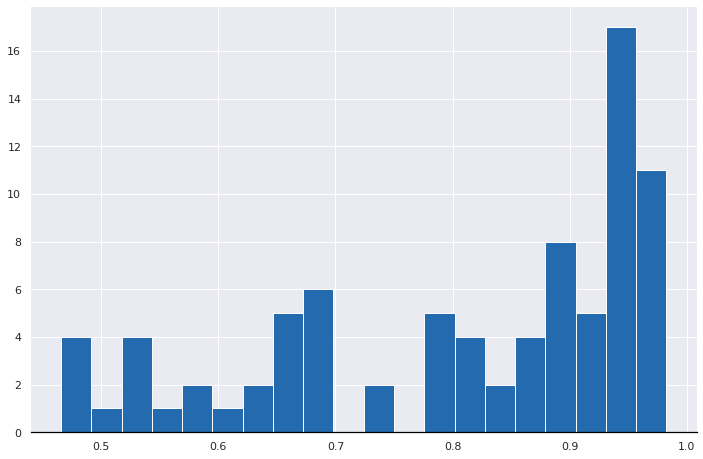

In [46]:
# A histogram for a given metric where each observation is a permutation
analyze_object.plot_hist('val_accuracy', bins=20)

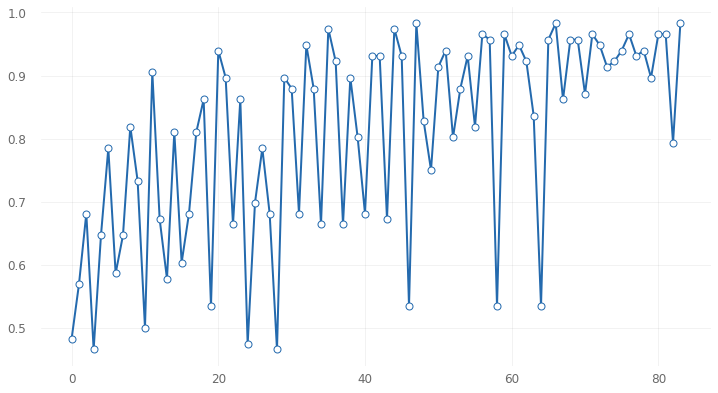

In [47]:
# A round-by-round line graph for a given metric
analyze_object.plot_line('val_accuracy')

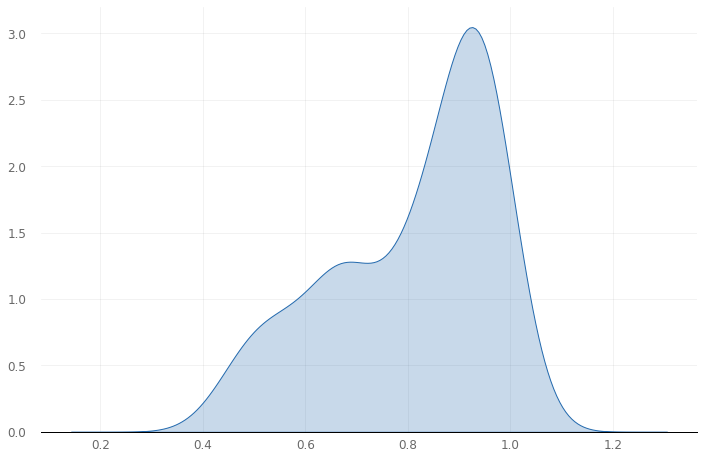

In [48]:
# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_accuracy')

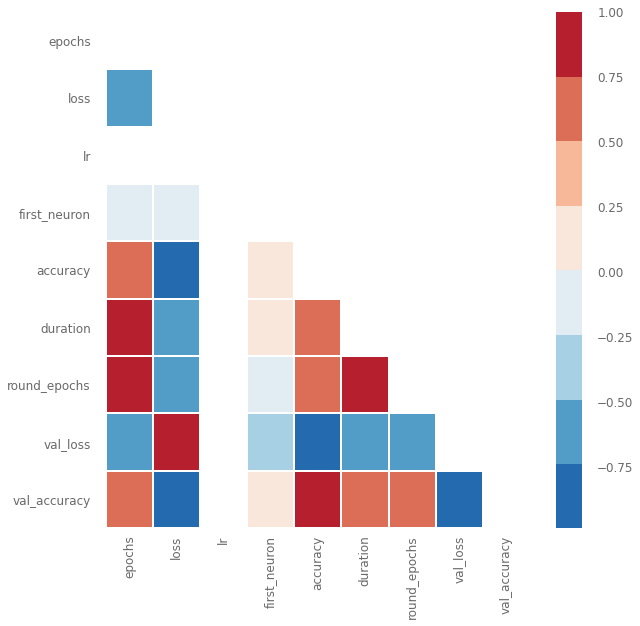

In [49]:
# A correlation heatmap where a single metric is compared against hyperparameters
analyze_object.plot_corr(metric='val_accuracy', exclude=['val_accuracy'])

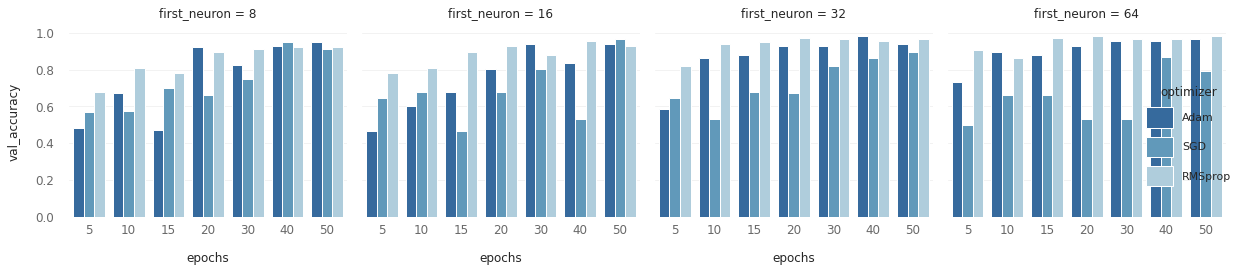

In [50]:
# a four dimensional bar grid
analyze_object.plot_bars(x='epochs', y='val_accuracy', hue='optimizer', col='first_neuron')

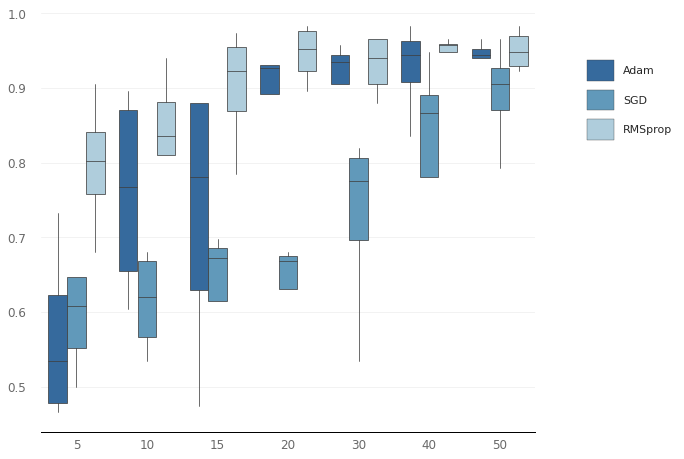

In [51]:
analyze_object.plot_box(x='epochs', y='val_accuracy', hue='optimizer')

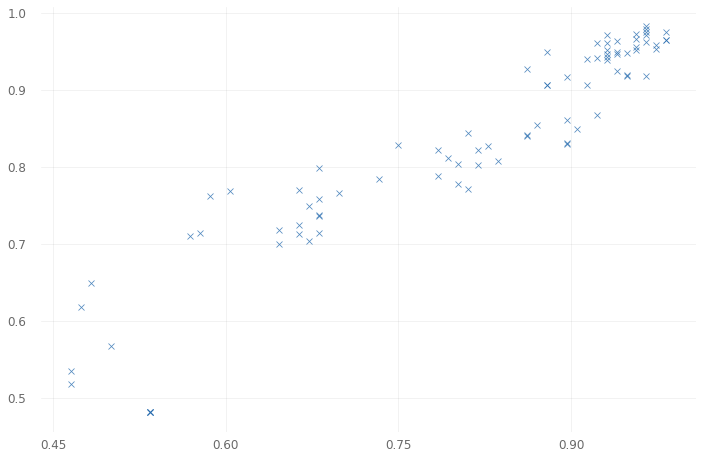

In [52]:
analyze_object.plot_regs(x='val_accuracy', y='accuracy')

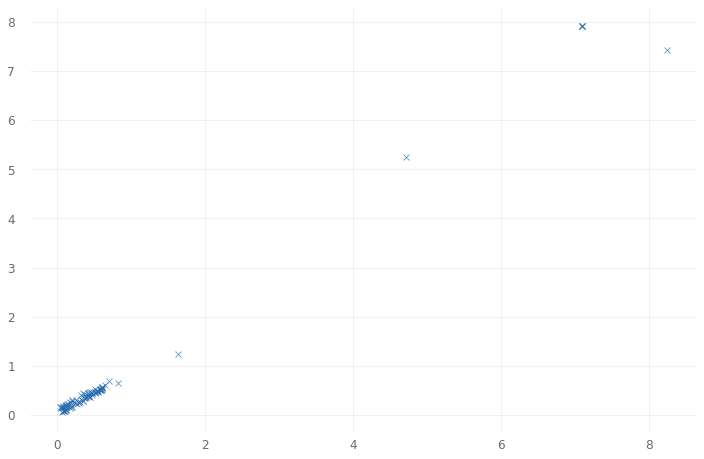

In [53]:
analyze_object.plot_regs(x='val_loss', y='loss')

In [54]:
analyze_object.best_params('val_accuracy', exclude=[])

array([['binary_crossentropy', '12/09/20-002233', 50,
        0.17236627638339996, 0.0001, '12/09/20-002219', 64,
        0.9750000238418579, 13.570618629455566, 50, 0.04543815553188324,
        'RMSprop', 0],
       ['binary_crossentropy', '12/09/20-001923', 40, 0.153865247964859,
        0.0001, '12/09/20-001914', 32, 0.9649999737739563,
        9.250789403915405, 40, 0.055955514311790466, 'Adam', 1],
       ['binary_crossentropy', '12/09/20-001648', 20,
        0.16773869097232819, 0.0001, '12/09/20-001641', 64,
        0.9649999737739563, 7.019955635070801, 20, 0.0822514072060585,
        'RMSprop', 2],
       ['binary_crossentropy', '12/09/20-001627', 20, 0.18583944439888,
        0.0001, '12/09/20-001621', 32, 0.9574999809265137,
        5.615765571594238, 20, 0.11392123252153397, 'RMSprop', 3],
       ['binary_crossentropy', '12/09/20-001538', 15,
        0.18887203931808472, 0.0001, '12/09/20-001532', 64,
        0.9524999856948853, 5.758772134780884, 15, 0.12505799531936646,
 

In [55]:
best_params = analyze_object.best_params('val_accuracy', exclude=[], n=1)

In [56]:
best_params

array([['binary_crossentropy', '12/09/20-002233', 50,
        0.17236627638339996, 0.0001, '12/09/20-002219', 64,
        0.9750000238418579, 13.570618629455566, 50, 0.04543815553188324,
        'RMSprop', 0]], dtype=object)

In [57]:
'''
Source:
https://autonomio.github.io/docs_talos/#evaluate
#from talos import Predict, Evaluate

Evaluate the best performing model with 10-fold cross validation.
'''
evaluate_object = ta.Evaluate(scan_object)
#e.evaluate(X_test, y_test, average='macro', metric='val_accuracy')
evaluate_object.evaluate(X_test, y_test, task='binary', print_out=True, folds=10, metric='val_accuracy')

mean : 0.99 
 std : 0.03


[1.0, 0.923076923076923, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0]

In [58]:
'''
# Source:
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb

Save best performing model to use at a later point.
'''
#import time
#t = time.time()
#ta.Deploy(t, 'deployed_model', metric='val_accuracy')
#path_to_model = '/content/drive/My Drive/CS5824/data/final-project/Models/{}'.format(int(t))
path_to_model = 'deployed_model_3'
ta.Deploy(scan_object, path_to_model, 'val_accuracy')

Deploy package deployed_model_3 have been saved.


In [59]:
!pwd

/content


In [60]:
!ls

deployed_model_1      deployed_model_2	    deployed_model_3.zip  exp_run_1
deployed_model_1.zip  deployed_model_2.zip  drive		  sample_data


In [61]:
!cp deployed_model_3.zip '/content/drive/My Drive/CS5824/data/final-project/Models/'

In [62]:
'''
**************************************
Restore function from Talos API
currently not working with 3D models!
**************************************

Source:
https://github.com/autonomio/talos/issues/521

Use the Talos API to restore the best performing model
to use and predict stock/ETF movements at a later point.
'''
#etf_predicter = ta.Restore('/content/drive/ETF_deploy.zip') 
#from talos.commands.restore import Restore
from talos import Restore
#restored_model = Restore('/content/drive/My Drive/CS5824/data/final-project/Models/deployed_model_1.zip')
restored_model = Restore('/content/deployed_model_3.zip')

In [63]:
'''
View the details of the restored model
'''
restored_model.details

,0,1
0,NaN,0
1,experiment_name,exp_run_1
2,random_method,uniform_mersenne
3,reduction_method,NaN
4,reduction_interval,50
5,reduction_window,20
6,reduction_threshold,0.2
7,reduction_metric,val_acc
8,complete_time,12/09/20/00:22
9,x_shape,"(800, 18)"


In [64]:
'''
View the hyper parameters of the restored model.
'''
restored_model.params

{'epochs': [5, 10, 15, 20, 30, 40, 50],
 'first_neuron': [8, 16, 32, 64],
 'losses': ['binary_crossentropy'],
 'lr': (0.0001, 0.001, 0.005, 0.05, 0.01),
 'optimizer': ['Adam', 'SGD', 'RMSprop']}

In [65]:
'''
View the Keras model summary of the restored model.
'''
restored_model.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [66]:
'''
Validate that prediction function still works
with a restored model.
'''
restored_model.model.predict(X_test)

array([[-1.3016552 ],
       [ 0.5591232 ],
       [-0.7578116 ],
       [-2.4515388 ],
       [ 2.943721  ],
       [-2.7874053 ],
       [ 0.7452262 ],
       [ 3.5190728 ],
       [ 2.5482447 ],
       [-1.4218096 ],
       [-1.719401  ],
       [-1.7893255 ],
       [ 2.880151  ],
       [-1.974032  ],
       [-2.441993  ],
       [-1.5427393 ],
       [ 6.4823046 ],
       [ 9.737197  ],
       [ 1.4412999 ],
       [ 5.239473  ],
       [ 6.106659  ],
       [ 1.9240779 ],
       [ 2.6546574 ],
       [ 4.942547  ],
       [-3.4907424 ],
       [ 4.6249785 ],
       [-0.4304804 ],
       [ 1.1899697 ],
       [ 2.0094354 ],
       [ 1.9907027 ],
       [-1.5933057 ],
       [ 5.4772854 ],
       [ 1.9357818 ],
       [ 2.4287598 ],
       [ 0.9408672 ],
       [ 2.1816015 ],
       [-0.05824545],
       [ 1.0977437 ],
       [ 4.53253   ],
       [ 2.1204267 ],
       [-0.1323692 ],
       [ 1.0807798 ],
       [ 0.4470627 ],
       [ 0.39236856],
       [-1.4981632 ],
       [-1

# <a name="Sources"></a>Sources

1. https://www.kaggle.com/kratisaxena/lstm-gru-models-for-stock-movement-analysis#LSTM-Model-for-Prediction-of-movement-of-stocks
2. https://github.com/borisbanushev/stockpredictionai
3. https://www.kaggle.com/jacksoncrow/stock-market-dataset
4. https://github.com/autonomio/talos

In [72]:
!jupyter nbconvert --to PDF "/content/drive/My Drive/Colab Notebooks/AdvML_FinalProject_BarryStraume_Jostein.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/AdvML_FinalProject_BarryStraume_Jostein.ipynb to PDF
[NbConvertApp] Support files will be in AdvML_FinalProject_BarryStraume_Jostein_files/
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume_Jostein_files
[NbConvertApp] Making directory ./AdvML_FinalProject_BarryStraume